# Part 3: Practice

This is the last part of IIC tutorial. Here we try to use it for clustering and semi-supervised classification of MNIST.
Some useful functions are implemented in [utils](https://github.com/vandedok/IIC_tutorial/blob/master/tutorial/utils.py) and in [preprocess](https://github.com/vandedok/IIC_tutorial/blob/master/tutorial/preprocess.py) modules. Feel free to look there if you want to understand how everything works in detail.

If you a working in Google colab you need to do  a coouple of additional moves. First, go to "Runtime" menu, click on "Change runtme type", and select GPU option in "Runtime type
Hardware accelerator" menu. After this uncomment and run the cell below. When the execution is finished, restart the runtime.

In [1]:
# !curl https://raw.githubusercontent.com/vandedok/IIC_tutorial/master/tutorial/requirements_colab.txt --output requirements_colab.txt
# !curl https://raw.githubusercontent.com/vandedok/IIC_tutorial/master/tutorial/utils.py --output utils.py
# !curl https://raw.githubusercontent.com/vandedok/IIC_tutorial/master/tutorial/preprocess.py --output preprocess.py
# !pip install -r requirements_colab.txt

Imports

In [150]:
import random
import os
import sys

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
# warnings.simplefilter(action='ignore', category=UserWarning)
import numpy as np
import torch
from torch import nn
import albumentations as A
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.metrics.cluster import homogeneity_score, completeness_score

from utils import (
    visualize_augmentations,
    weight_init,
    print_while_trainig,
    get_cluster_labeling,
    visualise_clusetering_results,
    stratified_split,
)
from utils import create_mapping, print_mapping
from preprocess import create_MNIST_arrays, manually_download_MNIST

In [151]:
# This  should  enable automatic downloading of MNIST
from six.moves import urllib

opener = urllib.request.build_opener()
opener.addheaders = [("User-agent", "Mozilla/5.0")]
urllib.request.install_opener(opener)

In [152]:
# Fix torch randomization for reproducability
torch.manual_seed(42)

## Preprocessing the data

First of all we define the augmentations, which are one of the key elements of IIC approach. I use Albumentations library to compose horizontal flips, rotations, perspective changes, superpixels, noise, brightness and contrast transforms. Each of theses transforms can be applied with a certain probability to an input image.

In [153]:
alb_transforms = A.Compose(
    [
        A.HorizontalFlip(),
        A.Rotate(limit=20, p=0.6),
        A.IAAPerspective(scale=(0.1, 0.1), p=0.1),
        A.IAASuperpixels(p_replace=0.2, p=0.6),
        A.IAAAdditiveGaussianNoise(scale=(0.1 * 255, 0.2 * 255), p=0.6),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
    ]
)

Now we need to define a dataset. We can do it in a usual way, by inheriting MNIST dataset class and editing the transforms call in ```__getitem__``` method like [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). However this approach has a huge drawback -- at each call a new augmentation is computed, so during the training a lot of time is spent not on the forward and backward runs, but on getting an augmented batch. To avoid this, we precompute the augmentations in advance  and save them in RAM. It is done in the ```RAMAugMNIST``` class, which you can see below. In fact all the preprocessing is done in ```create_MNIST_arrays```  function from [preprocessing module](link_to_preprocessing_module).

In [154]:
class RAMAugMNIST(Dataset):
    """The dataset contatining the original and augmented data in RAM

    Attributes
    ----------
    original_dataset : numpy.ndarray
        shape (N,...) where N is the number of data samples, and "..." stands for
        the shape of a single data sample. The array with riginal images.
    labels : numpy.ndarray
        shape (N,). Array of class labels
    aug_datasets : list of numpy.ndarray
        list of augmented datasets with the same shape as original_dataset
    aug_number : int
        number of augmentations
    """

    def __init__(
        self,
        images,
        augs_files=None,
        alb_transforms=A.Compose([]),
        aug_number=1,
        target_dir="./dataset",
        aug_batch_size=1024,
        aug_num_workers=1,
    ):
        """Datasetataset initialisation

        Parameters
        ----------
        augs_files : list of str
            list of pathes to binary np files with mnist augmentations. If this parameter is specifed,
            there is no need to pass other parameters
        alb_transforms : albumentations.core.composition.Compose
            a composition of Albumentations transforms. Ignored if augs_files is specified.
        aug_number : int
            number of augmentations to make. Ignored if augs_files is specified.
        target_dir : str
            dir to store the dataset. Ignored if augs_files is specified.
        batch_size : int
            size of batch used in augmentation. Ignored if augs_files is specified.
        num_workers : int
            number of CPU threads to use in augmentations. Ignored if augs_files is specified.

        """

        if augs_files is not None:
            aug_number = 0

        self.original_dataset, self.aug_datasets = create_MNIST_arrays(
            alb_transforms=alb_transforms,
            aug_number=aug_number,
            images=images,
            target_dir=target_dir,
            batch_size=aug_batch_size,
            num_workers=aug_num_workers,
        )
        self.aug_number = aug_number

        if augs_files is not None:
            print("Loading augmented datasets...", end=" ")
            self.aug_datasets = [np.load(x) for x in augs_files]
            self.aug_number = len(augs_files)
            print("Done!")

    def save_augs(self, dataset_dir):
        """saves augmentations as binary np files"""

        print("Saving augs in %s..." % dataset_dir, end=" ")
        for aug_idx, aug_array in enumerate(self.aug_datasets):
            file_path = os.path.join(dataset_dir, "mnist_aug_" + str(aug_idx) + ".np")
            with open(file_path, "wb") as file:
                np.save(file, aug_array)
        print("Done!")

    def __len__(self):
        """returns the length of the dataset"""
        return self.original_dataset.shape[0]

    def __getitem__(self, idx):
        """Returns the dataset sample and index idx

        Returns
        -------
        return_dict : dict
            dict with the following keys:
            "original" : numpy.ndarray
                original image taken from self.original_dataset
            "aug" : numpy.ndarray
                augmented image taken randomly from one of self.aug_datasets
            "label" : int
                run label of the image taken form self.labels
        """
        type(idx)
        original_image = np.array(
            self.original_dataset[idx : idx + 1, :, :], copy=True, dtype=np.float32
        )
        # label = np.array(self.labels[idx], copy=True, dtype=np.float32)

        return_dict = {"original": original_image}

        if self.aug_number > 0:
            aug_version = int(self.aug_number * random.random())
            aug_image = np.array(
                self.aug_datasets[aug_version][idx : idx + 1, :, :],
                copy=True,
                dtype=np.float32,
            )
            return_dict["aug"] = aug_image

        return return_dict

If you want to see, how  it is implemented, feel free look at the  [preprocessing module](link_to_preprocessing_module). However for this tutorial it's sufficient to know, that at this stage several numpy arrays are created and stored in RAM: one containing the original MNIST, one containing the labels and several ones containing the augmented versions of MNIST. Now let's define the dataset dir:

In [155]:
DATASET_DIR = "./dataset/"

And create a dataset. I recommend to use 10 different augmentation (the ```aug_number``` parameter). However, if you don't want to wait it's possible to use less number of augmentations, say 5, and get a decent result:

<span style="font-size:larger;">WARNING: this cell can take several minutes to run! A simple way to improve the performance is to set num_workers equal to your computer CPU cores (2 for google colab) </span>

Now we perform the stratified train-val split of the dataset. This is needed for the semi-supervised classification setting. The validation part will be small -- only 600 images. We assume, that the train part has no labels so we are are not going to use them. Stratification is needed to make sure that each class is represented equally in the validation part.

In [156]:
import glob
import cv2
images = [cv2.imread(file) for file in glob.glob("Dataset_with_no_labels/*.png")]

In [157]:
dataset_np = RAMAugMNIST(
    images=images,
    alb_transforms=alb_transforms,
    aug_number=20,
    target_dir=DATASET_DIR,
    aug_batch_size=1024,
    aug_num_workers=11,
)

Fetching original dataset... Done!
Making aug #0


  0%|          | 0/1 [00:00<?, ?it/s]

Making aug #1


  0%|          | 0/1 [00:00<?, ?it/s]

Making aug #2


  0%|          | 0/1 [00:00<?, ?it/s]

Making aug #3


  0%|          | 0/1 [00:00<?, ?it/s]

Making aug #4


  0%|          | 0/1 [00:00<?, ?it/s]

Making aug #5


  0%|          | 0/1 [00:00<?, ?it/s]

Making aug #6


  0%|          | 0/1 [00:00<?, ?it/s]

Making aug #7


  0%|          | 0/1 [00:00<?, ?it/s]

Making aug #8


  0%|          | 0/1 [00:00<?, ?it/s]

Making aug #9


  0%|          | 0/1 [00:00<?, ?it/s]

Making aug #10


  0%|          | 0/1 [00:00<?, ?it/s]

Making aug #11


  0%|          | 0/1 [00:00<?, ?it/s]

Making aug #12


  0%|          | 0/1 [00:00<?, ?it/s]

Making aug #13


  0%|          | 0/1 [00:00<?, ?it/s]

Making aug #14


  0%|          | 0/1 [00:00<?, ?it/s]

Making aug #15


  0%|          | 0/1 [00:00<?, ?it/s]

Making aug #16


  0%|          | 0/1 [00:00<?, ?it/s]

Making aug #17


  0%|          | 0/1 [00:00<?, ?it/s]

Making aug #18


  0%|          | 0/1 [00:00<?, ?it/s]

Making aug #19


  0%|          | 0/1 [00:00<?, ?it/s]

In [158]:
dataset_train, dataset_val = stratified_split(dataset_np, train_size=0.8)

KeyError: 'label'

In [159]:
BATCH_SIZE = 20
dataloader_train = DataLoader(
    dataset_np, batch_size=BATCH_SIZE, shuffle=True, num_workers=16
)

Define the dataloaders:

In [160]:
# BATCH_SIZE = 20
# dataloader_train = DataLoader(
#     dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=16
# )
# dataloader_val = DataLoader(
#     dataset_val, batch_size=BATCH_SIZE, shuffle=True, num_workers=16
# )

It's useful to see how our augmentations look. It can be done with the ```visualize_augmentations``` from [utils](https://github.com/vandedok/IIC_tutorial/blob/master/tutorial/utils.py) module. Each run will fetch random augmentations.

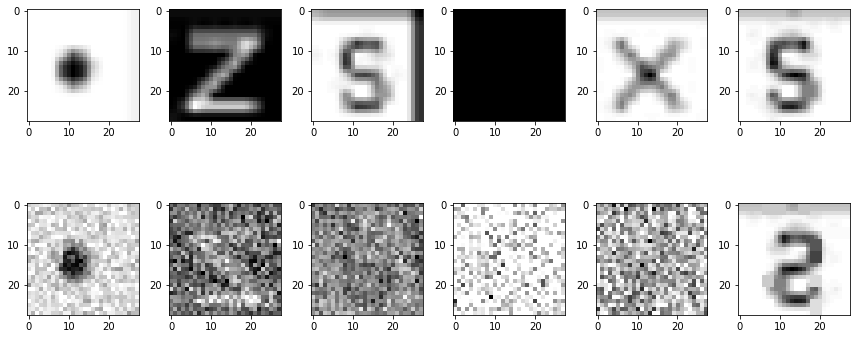

In [161]:
# visualize_augmentations(dataset_val, samples=6)
visualize_augmentations(dataset_np, samples=6)

Great! We successfully  preprocessed the data and ready to build a model.

## The model

It's time to define a clustering model based on resnet backbone. This is a really basic CV model with the only unusual part being the presence of two fully connected layers: ```clustering_head``` and ```overclustering_head```overclustering_head. The latter one is needed to improve the learning process (see <a href="https://arxiv.org/abs/1807.06653">original paper</a>  or appendix in [Part 1](https://github.com/vandedok/IIC_tutorial/blob/master/tutorial/part_1.md) of this tutorial).

Let's define a ResNet backbone, based, say, on  ResNat18 model. In IIC approach we don't expect the model to have any prior knowledge, so we set "pretrained" parameter to False.

In [162]:
resnet = models.resnet18(pretrained=False)

First we want to get bare CNN backbone. This means, that we need to cut a couple of layers from the top of the model. To see which ones we need to cut, lest print several last layers:

In [163]:
list(resnet.children())[-3:]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

The layers to cut are AdaptiveAvgPool2d and Linear:

In [164]:
modules_to_keep = list(resnet.children())[:-2]

The original ResNet18 model is designed to process to color images. We can adapt it to grayscale images by modifying the first layer:

In [165]:
print("The first layer:", modules_to_keep[0])

The first layer: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


All we need to do is to redefine this module with the same parameters except for the ```in_channels```:

In [166]:
modules_to_keep[0] = nn.Conv2d(
    1, 64, kernel_size=3, stride=1, padding=2, bias=False
)

In [167]:
print("The first layer:", modules_to_keep[0])

The first layer: Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), bias=False)


Now let's append Flatten layer and compose a backbone to see how many output features it has.

In [168]:
modules_to_keep.append(nn.Flatten())
backbone = nn.Sequential(*modules_to_keep)

To see the number of output features we define a batch of images. To speed up the computation we leave only tree images in our batch:

In [169]:
batch = next(iter(dataloader_train))["original"]
batch = batch[0:3]
print("Batch shape:", batch.shape)

Batch shape: torch.Size([3, 1, 28, 28])


 It's time to see how many features our backbone outputs:

In [170]:
print("Output shape:", backbone(batch).shape)

Output shape: torch.Size([3, 2048])


It has 512 features. We will use it to define clustering and overclustering heads:

In [171]:
final_features = 512
cluster_head = nn.Linear(final_features, 10)
overcluster_head = nn.Linear(final_features, 50)

Now let's gather everything into new ```nn.Module```:

In [172]:
class ResNetClusterisator(nn.Module):
    """Clusterisator for IIC based on ResNet18 backbone"""

    def __init__(self):
        super(ResNetClusterisator, self).__init__()
        # The number of output features we precomputed earlier
        final_features = 512

        # Define the backbone:
        resnet = models.resnet18(pretrained=False)
        modules = list(resnet.children())[:-2]
        modules[0] = nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        modules.append(nn.Flatten())
        self.backbone = nn.Sequential(*modules)

        # Define clustering and overculstering heads
        self.cluster_head = nn.Linear(final_features, 10)
        self.overcluster_head = nn.Linear(final_features, 50)

        # Define the softmax layer
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, overclustering=False):
        """Foward run. Can operate in both clustering an overclustering regimes

        Paraneters
        ----------
        x : torch.tensor
            input batch. The shape is supposed to be (B,1,28,28)
            where B is batch size
        overclustering : boolean
            if True, the overclustering head is used
            else the clustering head is used
        """
        x = self.backbone(x)
        if overclustering:
            x = self.overcluster_head(x)
        else:
            x = self.cluster_head(x)

        return self.softmax(x)

Now let's transfer our model to gpu and initialize the weights. Note, that in general different initializations can result in significantly different performance. Here we suppressed this effect by setting a manual seed at the beginning of the notebook.

In [173]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using %s." % device)
model = ResNetClusterisator()
model.to(device)
print("The model is transfered to %s." % device)
model.apply(weight_init)
print("The weights are Initialised.")

Using cpu.
The model is transfered to cpu.
The weights are Initialised.


Let's check that everything is fine by making a forward run:

In [174]:
batch = next(iter(dataloader_train))["original"]
batch = batch.to(device)
print("Model output shape in clustering mode:", model(batch).shape)
print("Model output shape in overclustering mode:", model(batch).shape)

Model output shape in clustering mode: torch.Size([20, 10])
Model output shape in overclustering mode: torch.Size([20, 10])


Fine! Let's proceed to the loss function.

## Mutual information loss

The second ingredient of IIC is a mutual information loss function. This code is based on the [original paper implementation](https://github.com/xu-ji/IIC/blob/master/code/utils/cluster/IID_losses.py#L6) with a minor changes. The mathematical details of  mutual information loss can be found in [Part 2](https://github.com/vandedok/IIC_tutorial/blob/master/tutorial/part_2.md) of this tutorial.

First we compute the estimation of the joint probability distribution

In [175]:
def compute_joint(x_out, x_tf_out):
    """Estimate a joint probability distribution

    Parameters
    ----------
    x_out : torch.tensor
        shape (B,C) where B is a batch size, C is a number of classes
        probabilities for the original batch
    x_out_tf: torch.tensor
        the same shape as x_out
        probabilities for the trasformed batch

    Returns
    -------
    p_i_j : torch.tensor
        shape (C,C) where C is a number of classes (the same as in x_out)
        joint probabilities

    """
    # multiplying probabilities
    p_i_j = x_out.unsqueeze(2) * x_tf_out.unsqueeze(1)  # bn, k, k

    # suminng over the batch_size
    p_i_j = p_i_j.mean(dim=0)

    # Symmetriztion
    p_i_j = (p_i_j + p_i_j.t()) / 2.0

    return p_i_j

And than the mutual information. Several tricks are used here. 

The first one is the regularization of joint probabilities. Recall, that what we compute mutual information we take the log of joints. When some joint probabilities $p_{ij}$ are small, $\log p_{ij}$ may be too large to be stored in float, so the NaN value will be returned. To avoid this we take a small value $\epsilon$ and replace with it all the joints which are less than $\epsilon$:

$$\forall p_{ij} < \epsilon: \log(p_{ij}) \quad\mathrm{is~replaced~with}\quad \log(\epsilon)$$

This is mathematically correct, as those logarithms come only in  such expressions as $p_{ij}\log(p_{ij})$, which goes to zero as $p_{ij}$ goes to zero.

The second one is the additional minus sign on in front of the mutual information. As we applied it, we need to minimize, not to maximize our loss.

In [176]:
def IID_loss(x_out, x_tf_out, lamb=1.0, EPS=sys.float_info.epsilon):
    """Compute mutual information loss. Theo overall minus sign is added so the loss should be minimized.

    Parameters
    ----------
    x_out : torch.tensor
        shape (B,C) where B is a batch size, C is a number of classes
        probabilities for the original batch
    x_out_tf: torch.tensor
        the same shape as x_out
        probabilities for the trasformed batch
    lambd : float
        parameter modyfing the loss.
        Larger lamb generally pushes the model towards putting
        spreading the samples to the different clusters of equal sizes.
        Smaller lambd pushes the model towards putting similar images to one cluster
    EPS : float
        parameter to regulerize small probabilities


    Returns
    -------
    loss : torch.tensor
        shape (1,). Mutual information loss

    """
    _, num_classes = x_out.size()

    # Estimate joint probabilities
    p_i_j = compute_joint(x_out, x_tf_out)
    assert p_i_j.size() == (num_classes, num_classes)

    # Trick to avoid NaN losses for small p_i_j
    mask = ((p_i_j > EPS).data).type(torch.float32)
    p_i_j = p_i_j * mask + EPS * (1 - mask)

    # Computing the marginals
    p_i = p_i_j.sum(dim=1).view(num_classes, 1).expand(num_classes, num_classes)
    p_j = p_i_j.sum(dim=0).view(1, num_classes).expand(num_classes, num_classes)

    # Compute the mutual information
    loss = -p_i_j * (torch.log(p_i_j) - lamb * torch.log(p_j) - lamb * torch.log(p_i))

    loss = torch.sum(loss)

    return loss

Thats all about the loss implemetation. Now let's go to the traning!

## Training

Let's take a look at IIC forward run. Our train dataloader will give us a batch with original images, transfomed images and labels:

In [177]:
batch = next(iter(dataloader_train))
print("Batch entities:", batch.keys(), end="\n\n")
print("Original images batch shape:     {0}".format(batch["original"].shape))
print("Transformed images batch shape:  {0}".format(batch["aug"].shape))
print("Labels batch shape:              {0}".format(batch["label"].shape))

Batch entities: dict_keys(['original', 'aug'])

Original images batch shape:     torch.Size([20, 1, 28, 28])
Transformed images batch shape:  torch.Size([20, 1, 28, 28])


KeyError: 'label'

We are not using labels in training. 


After fetching the batches we transfer them to the gpu:

In [178]:
inputs = batch["original"]
inputs_tf = batch["aug"]

inputs = inputs.to(device=device)
inputs_tf = inputs_tf.to(device=device)

And than computing the outputs, the loss and make a backward run:

In [179]:
overclustering = False
lamb = 1.0
outputs = model(inputs, overclustering)
outputs_tf = model(inputs_tf, overclustering)
loss = IID_loss(outputs, outputs_tf, lamb=lamb)
print(loss.data.cpu().numpy())
loss.backward()

-0.035681173


That's it! 

Before rushing into training we need a funtion to evaluate the loss. It just iterates over dataloader, makes the forward run and computes  the mean loss:

In [180]:
def evaluate(
    model, dataloader, overclustering=False, lamb=1.0, device=torch.device("cpu")
):
    """Calculates the model mean loss. The average is taken over the batches."""

    losses = []
    # switch model to the eval state to prevent the training
    model.eval()

    for i, batch in enumerate(dataloader):

        # forward run
        inputs = batch["original"]
        inputs_tf = batch["aug"]
        with torch.no_grad():

            inputs = inputs.to(device=device)
            inputs_tf = inputs_tf.to(device=device)

            outputs = model(inputs, overclustering)
            outputs_tf = model(inputs_tf, overclustering)

        loss = IID_loss(outputs, outputs_tf, lamb=lamb)

        # combining the losses for all batches into a single list
        losses.append(loss.data.cpu().numpy())

    # output the mean loss
    return np.mean(losses)

Recall, that in [Part 1](https://github.com/vandedok/IIC_tutorial/blob/master/tutorial/part_1.md) we discussed, that our model can greatly benefit from switching between clustering and overculstering. Here we implement it in a following way:

In [181]:
def choose_clustering_regime(epoch, overcluster_period, overcluster_ratio):
    """Choice of the clustering regime based on the epoch number

    Parameters
    ----------
    epoch : int
        current epoch number
    overcluster_period : int
        total period for both clustering and overclustering
    overcluster_ratio : float
        a fraction of time to spend on overclustering
    """

    if (
        overcluster_period is not None
        and epoch % overcluster_period < overcluster_period * overcluster_ratio
    ):
        return True
    else:
        return False

Now it's time to combine the forward run and the backward run in a training loop. I have also put some printing stuff here, so you can observe loss evolution during the training.  

In [182]:
def IIC_train(
    modeldataset,
    dataloader,
    optimizer,
    epochs=100,
    device=torch.device("cpu"),
    eval_every=5,
    lamb=1.0,
    overcluster_period=20,
    overcluster_ratio=0.5,
):
    """IIC training loop

    Parameters
    ----------
    model : ResNetClusterisator
        the IIC model to train
    dataloader : torch.utils.data.dataloader.DataLoader
        dataloader to fetch the data
    optimizer : torch.optim.optimier like
        your favourite optimzer
    epochs : int
        total number of epoches
    device : torch.device
        device which sould perform the trainig
    eval_every : int
        the freqency of evaluation
    lamb : float
        paramter to modyfy IID_loss (see IID_loss)
    overcluster_period : int
        total period for both clustering and overclustering
    overcluster_ratio : float
        a fraction of time to spend on overclustering
    """

    # Lists to store epochs numbers and losses for visualisation
    epochs_list = []
    loss_history = []
    loss_history_overclustering = []

    # Variables for best losses
    best_cluster_loss = 0
    best_overcluster_loss = 0

    # Progress bar instance
    pbar = tqdm(total=len(dataloader), leave=False, desc="Epoch")

    for epoch in range(epochs):

        # Switching the model to train mode
        model.train()
        # Define where the epoch is dedicated to clustering or overclustering
        overclustering = choose_clustering_regime(
            epoch, overcluster_period, overcluster_ratio
        )

        # Reseting the progress bar
        pbar.reset()
        pbar.desc = "Epoch #%i" % epoch

        for i, batch in enumerate(dataloader):

            # Nullifing the gradients
            optimizer.zero_grad()

            # Forward run
            inputs = batch["original"]
            inputs_tf = batch["aug"]

            inputs = inputs.to(device=device)
            inputs_tf = inputs_tf.to(device=device)

            outputs = model(inputs, overclustering)
            outputs_tf = model(inputs_tf, overclustering)
            loss = IID_loss(outputs, outputs_tf, lamb=lamb)

            # Backward run
            loss.backward()

            # Updating the weights
            optimizer.step()

            # Updating the progreess bar
            pbar.update(1)

        # Evaluation section
        if (epoch + 1) % eval_every == 0:

            # Computing eval losses
            loss_eval = evaluate(
                model, dataloader, overclustering=False, lamb=lamb, device=device
            )
            loss_eval_overclustering = evaluate(
                model, dataloader, overclustering=True, lamb=lamb, device=device
            )

            loss_history.append(loss_eval)
            loss_history_overclustering.append(loss_eval_overclustering)
            epochs_list.append(epoch)

            # Saving the model with best evaluation loss
            if loss_eval < best_cluster_loss:
                best_cluster_loss = loss_eval
                torch.save(model.state_dict(), "best_loss_model")

            pbar.close()

            # Visualising the training
            print_while_trainig(epochs_list, loss_history, loss_history_overclustering)

            pbar = tqdm(total=len(dataloader), leave=False, desc="Epoch")

Let's begin the training

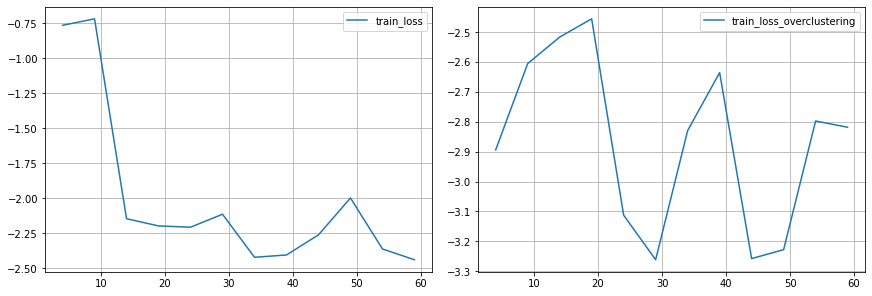

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

In [183]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=4e-4,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0,
    amsgrad=False,
)
IIC_train(
    model,
    dataloader_train,
    optimizer,
    device=device,
    epochs=60,
    lamb=1.2,
    overcluster_period=20,
    overcluster_ratio=0.5,
)

You should see a couple non-monotonously decaying lines. When the model is in the clustering mode, overclusetring loss can grow and vice versa. However after about 60 epochs the clustering loss reaches plateau and the training can be stopped.

## Evaluation

It's time to evaluate our model performance. Firstly we load the model which showed the best loss on train data:

In [184]:
model.load_state_dict(torch.load("best_loss_model"))

<All keys matched successfully>

### Clustering

Than we compose two labelings -- the original one and the one which is outputted by the model. Note, that in a fair clustering setting the original labels are not available, so this method is applicable only in testing _clustering method_ on a labeled dataset. 

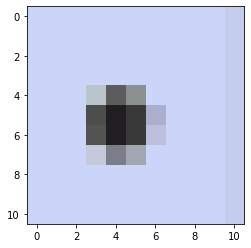

___ 7


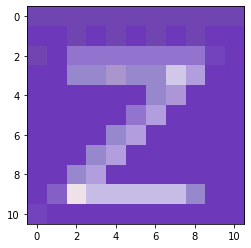

___ 2


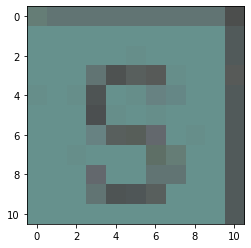

___ 9


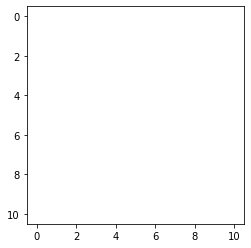

___ 8


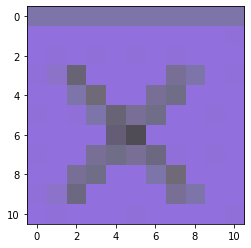

___ 5


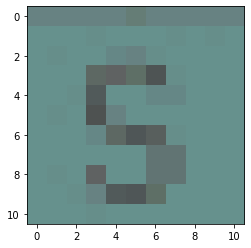

___ 9


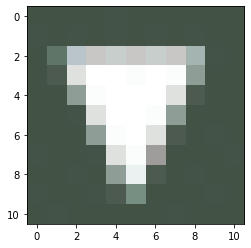

___ 0


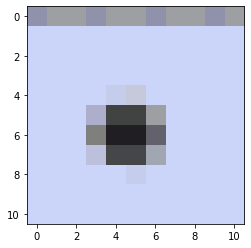

___ 7


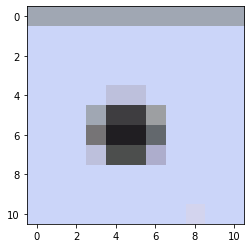

___ 7


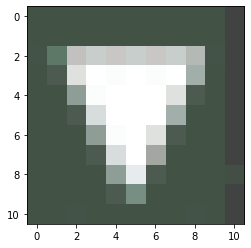

___ 0


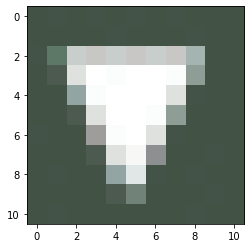

___ 0


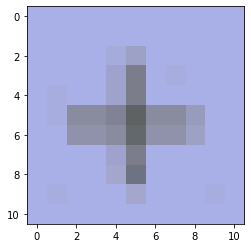

___ 6


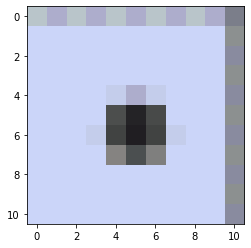

___ 7


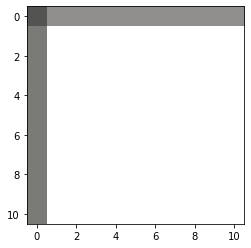

___ 9


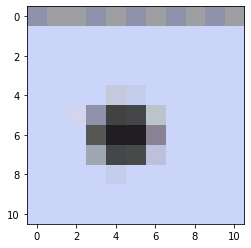

___ 7


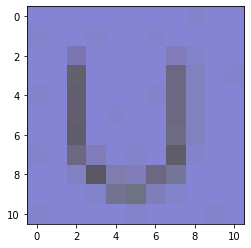

___ 3


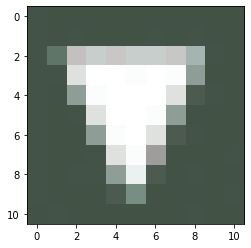

___ 0


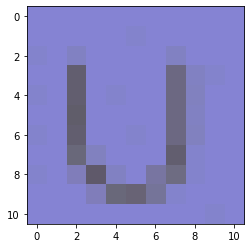

___ 3


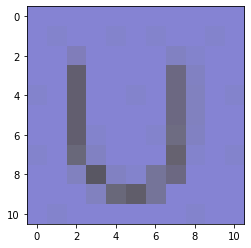

___ 3


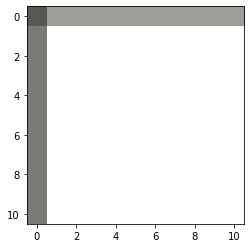

___ 9


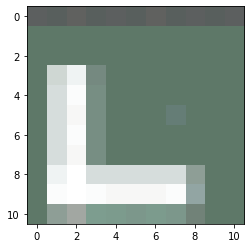

___ 4


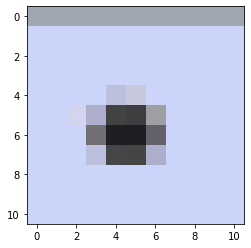

___ 7


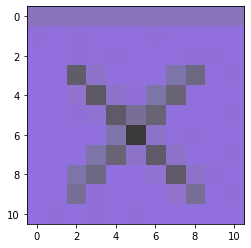

___ 5


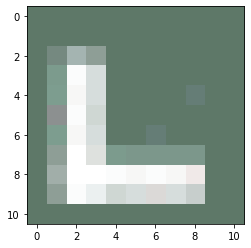

___ 4


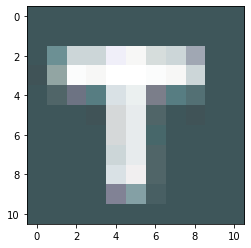

___ 1


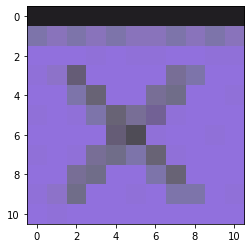

___ 5


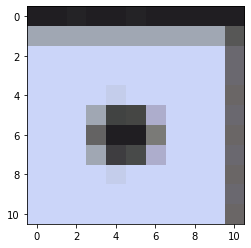

___ 9


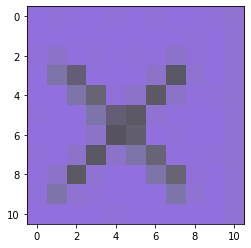

___ 3


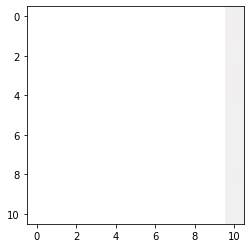

___ 8


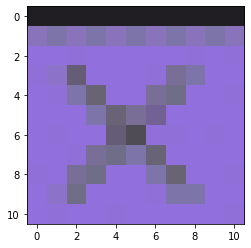

___ 5


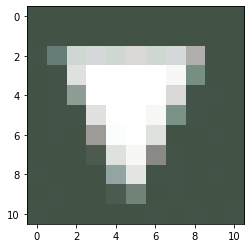

___ 0


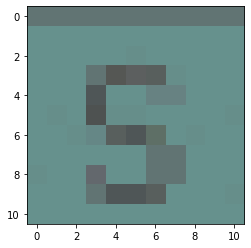

___ 5


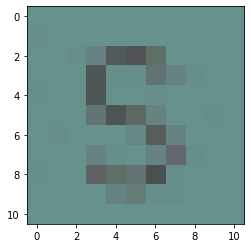

___ 6


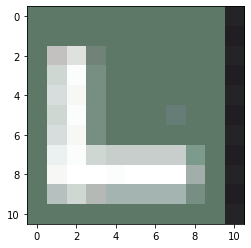

___ 4


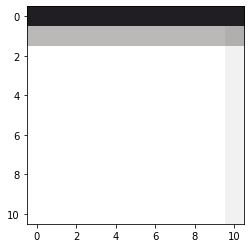

___ 5


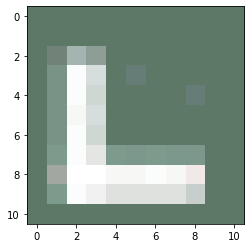

___ 4


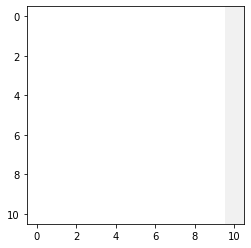

___ 8


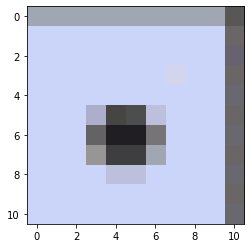

___ 7


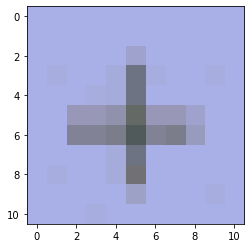

___ 7


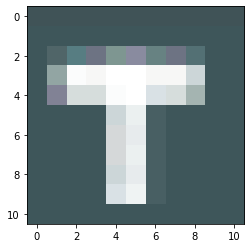

___ 1


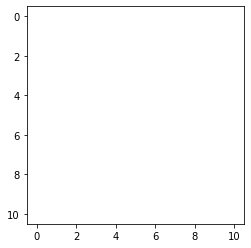

___ 8


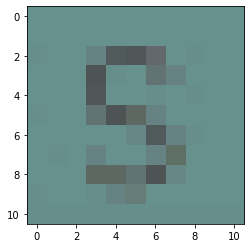

___ 6


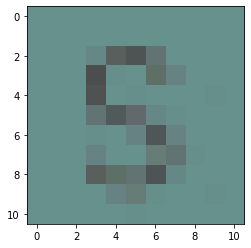

___ 6


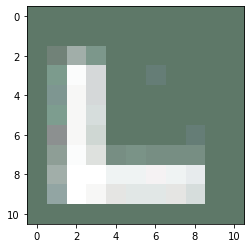

___ 4


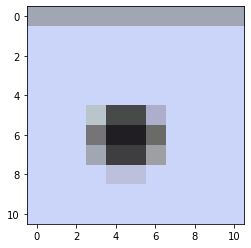

___ 7


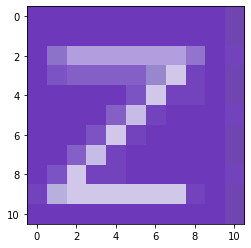

___ 2


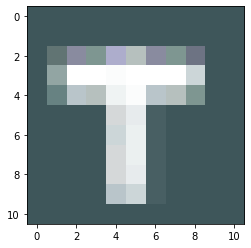

___ 1


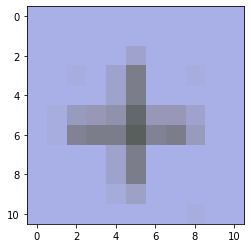

___ 7


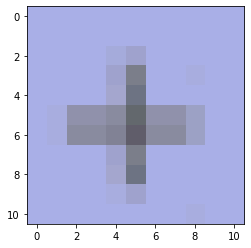

___ 7


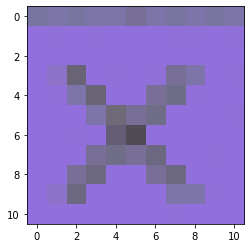

___ 5


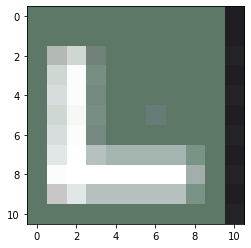

___ 4


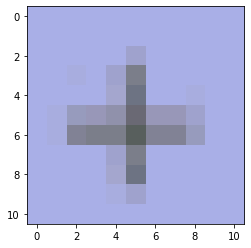

___ 7


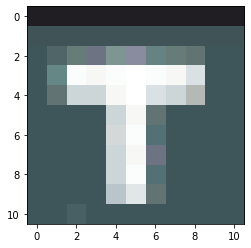

___ 1


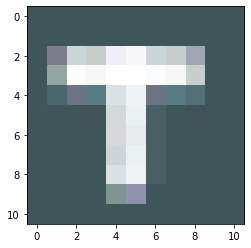

___ 1


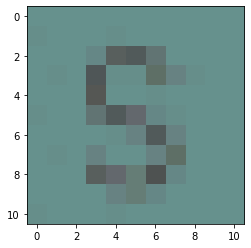

___ 3


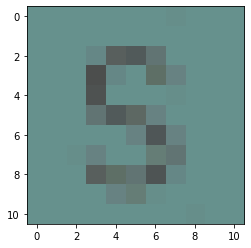

___ 6


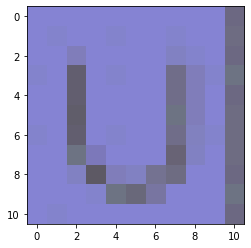

___ 3


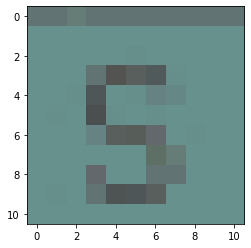

___ 9


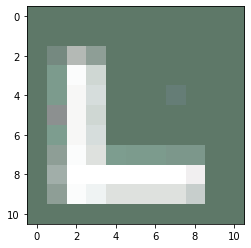

___ 4


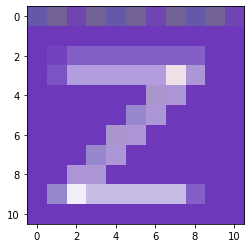

___ 2


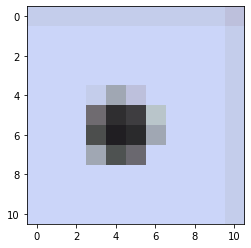

___ 7


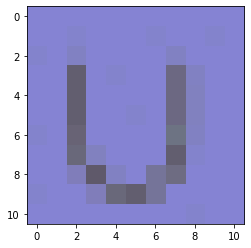

___ 3


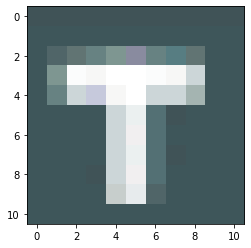

___ 1


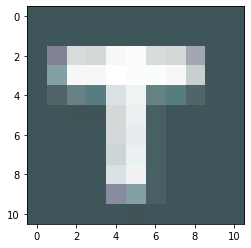

___ 1


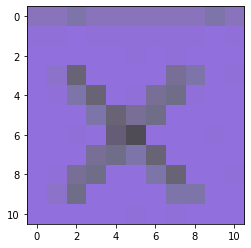

___ 5


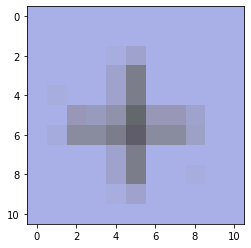

___ 7


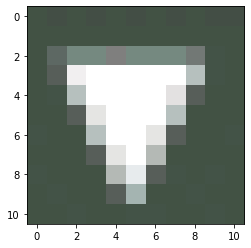

___ 0


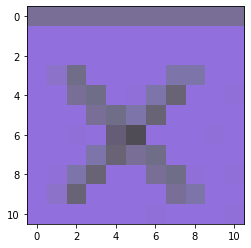

___ 5


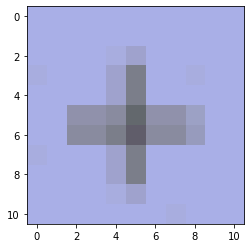

___ 7


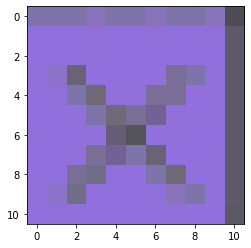

___ 5


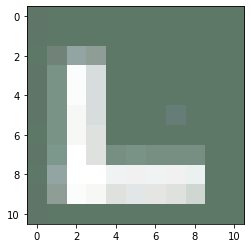

___ 4


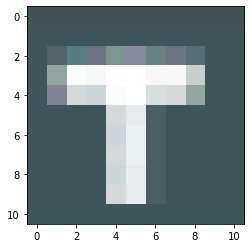

___ 1


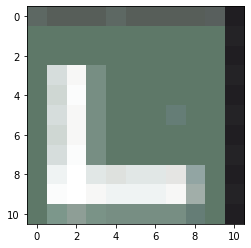

___ 4


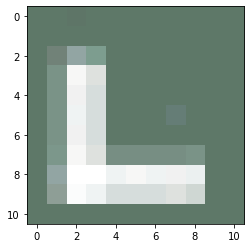

___ 4


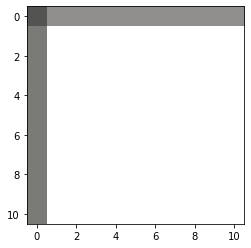

___ 9


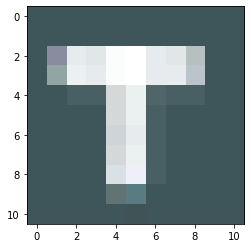

___ 1


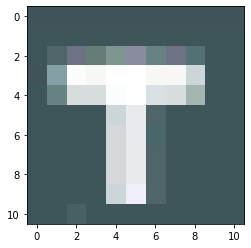

___ 1


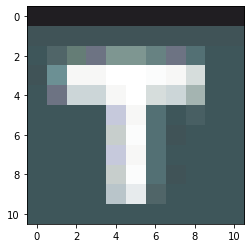

___ 1


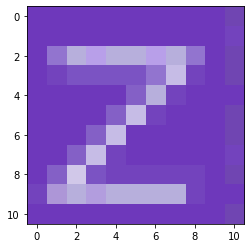

___ 2


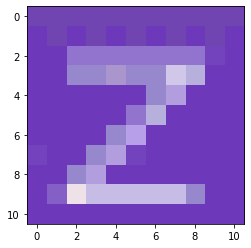

___ 2


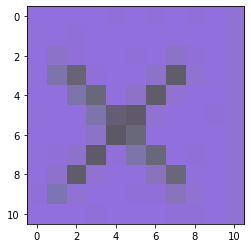

___ 3


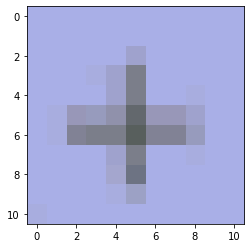

___ 7


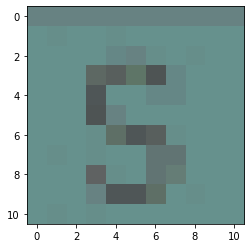

___ 9


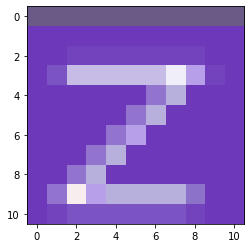

___ 2


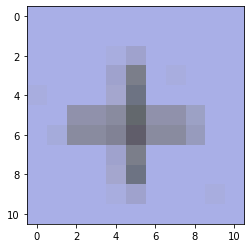

___ 7


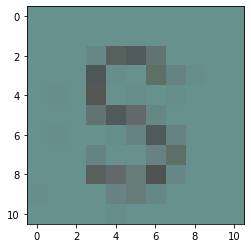

___ 3


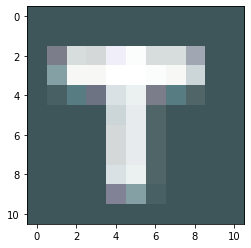

___ 1


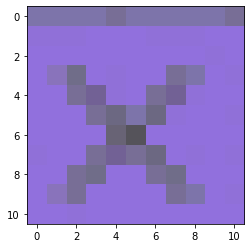

___ 5


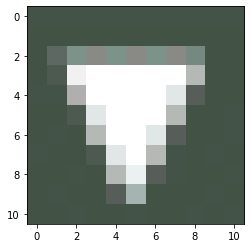

___ 0


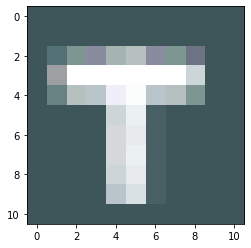

___ 1


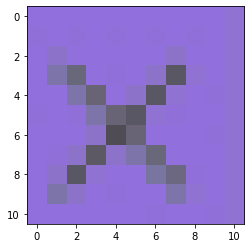

___ 3


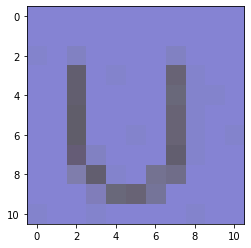

___ 3


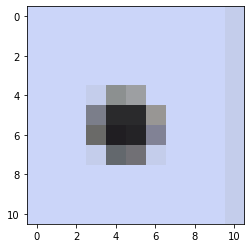

___ 7


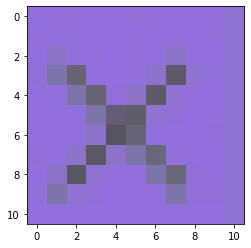

___ 3


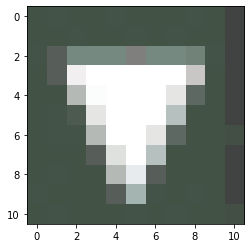

___ 0


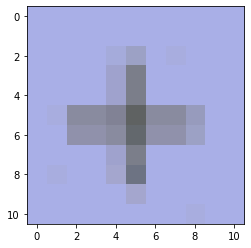

___ 6


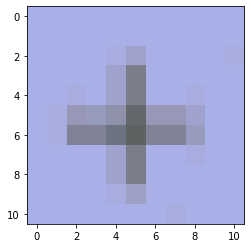

___ 7


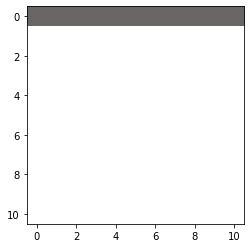

___ 5


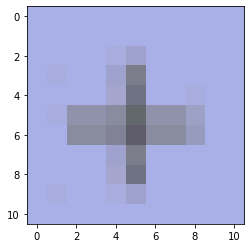

___ 7


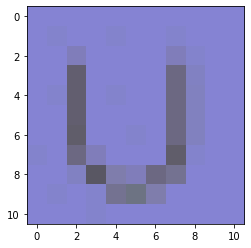

___ 3


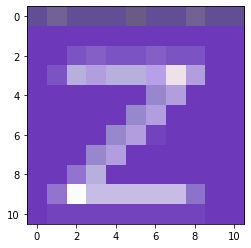

___ 2


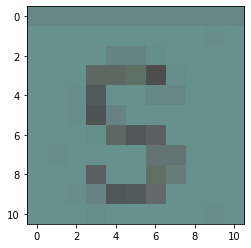

___ 9


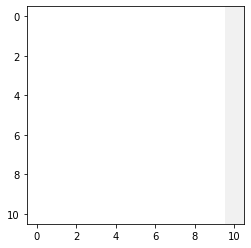

___ 8


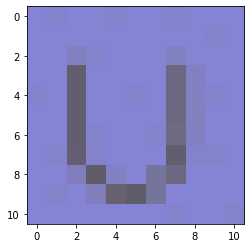

___ 3


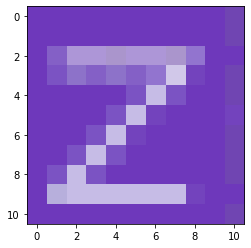

___ 2


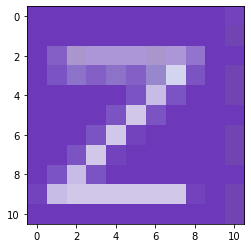

___ 2


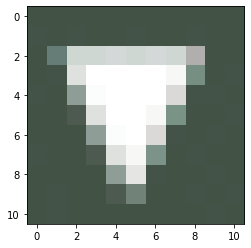

___ 0


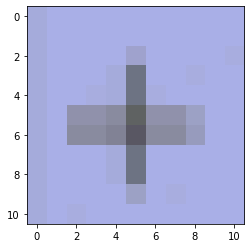

___ 7


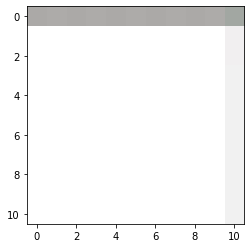

___ 5


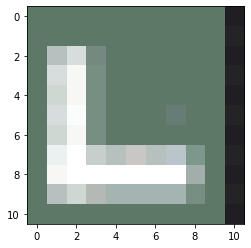

___ 4


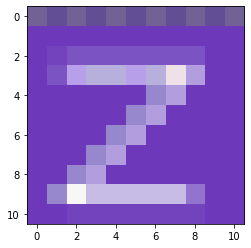

___ 2


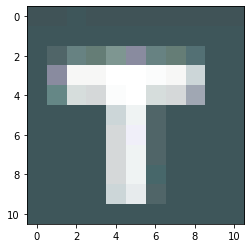

___ 1


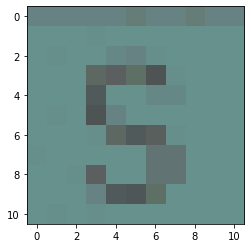

___ 9


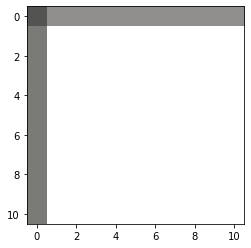

___ 9


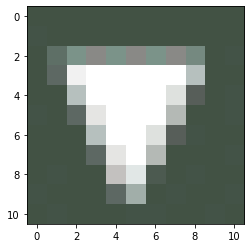

___ 0


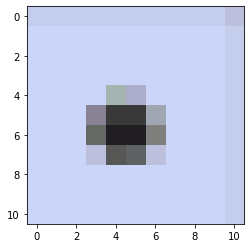

___ 7


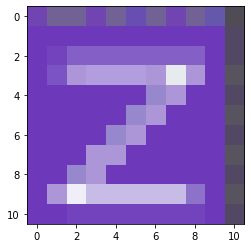

___ 2


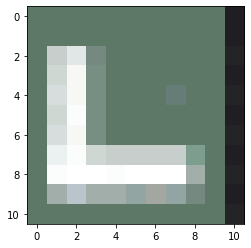

___ 4


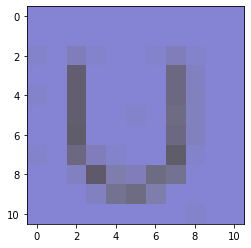

___ 3


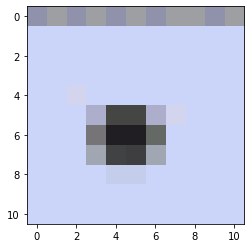

___ 7


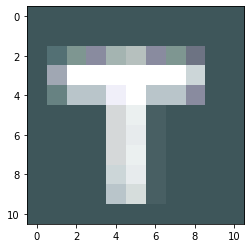

___ 1


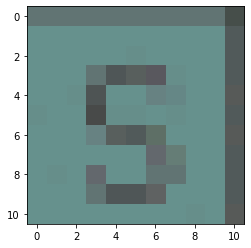

___ 9


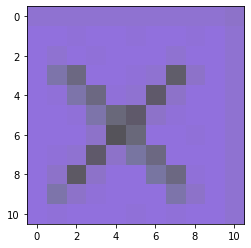

___ 3


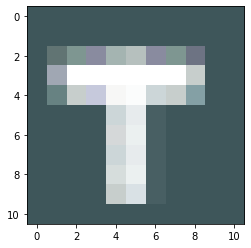

___ 1


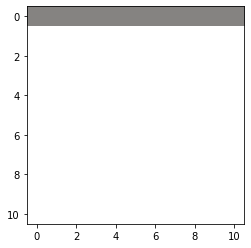

___ 5


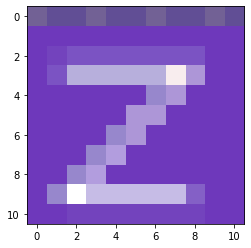

___ 2


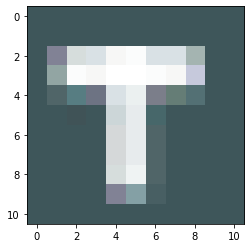

___ 1


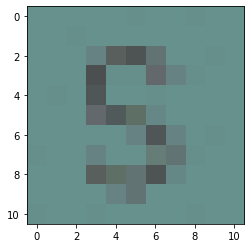

___ 6


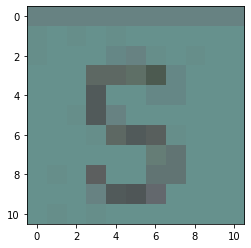

___ 9


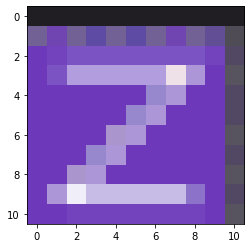

___ 2


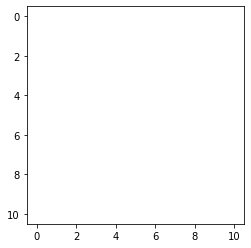

___ 8


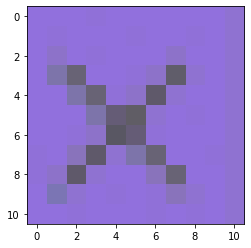

___ 3


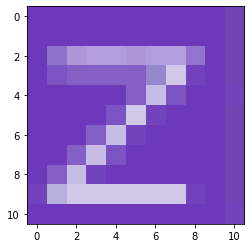

___ 2


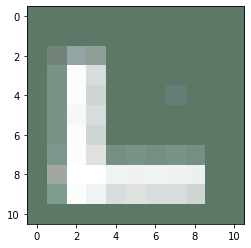

___ 4


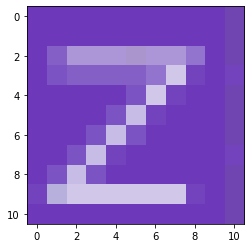

___ 2


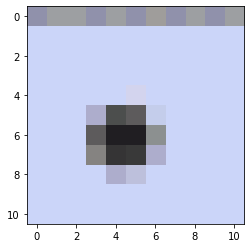

___ 7


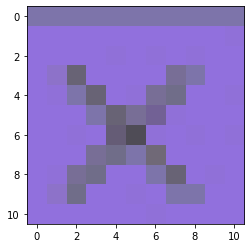

___ 5


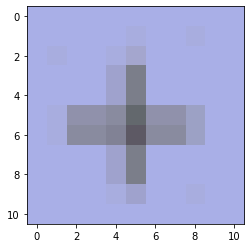

___ 7


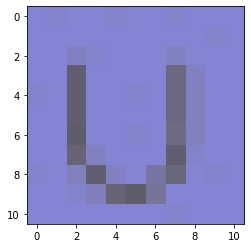

___ 3


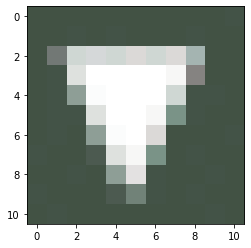

___ 0


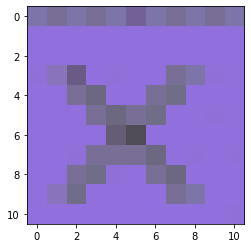

___ 5


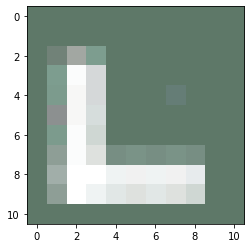

___ 4


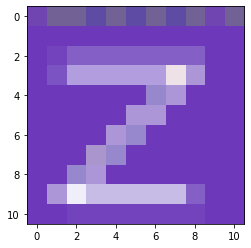

___ 2


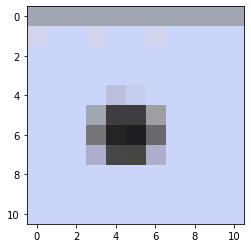

___ 7


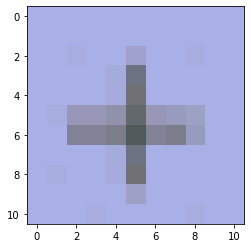

___ 7


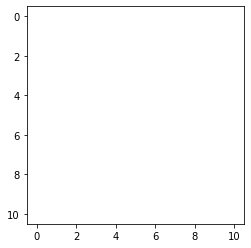

___ 8


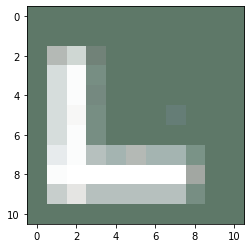

___ 4


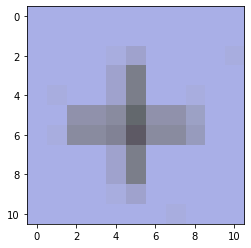

___ 7


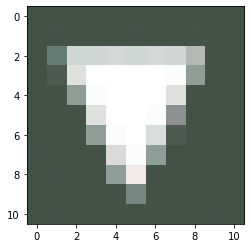

___ 0


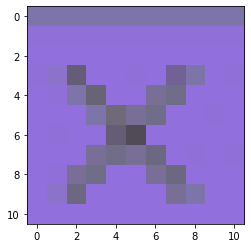

___ 5


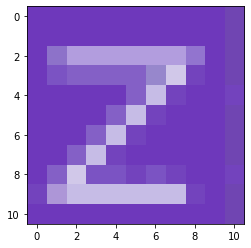

___ 2


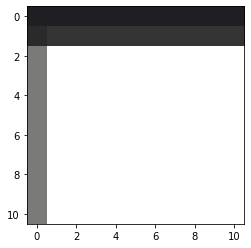

___ 9


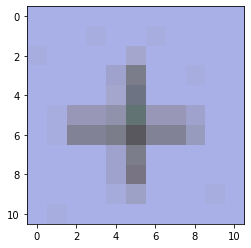

___ 7


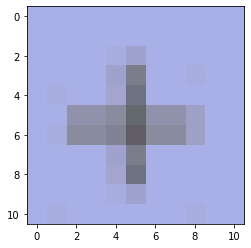

___ 7


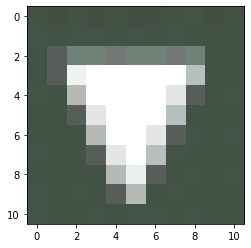

___ 0


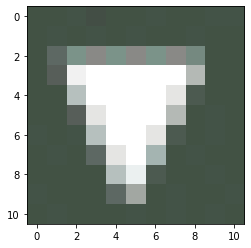

___ 0


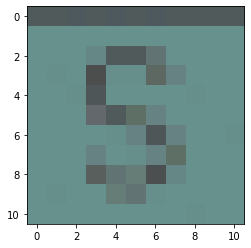

___ 5


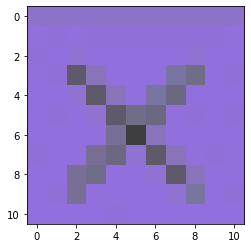

___ 5


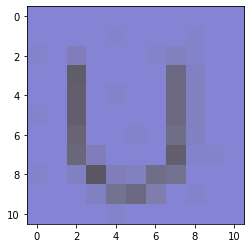

___ 3


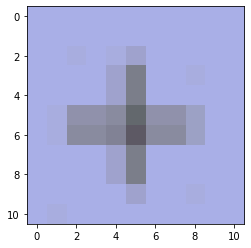

___ 7


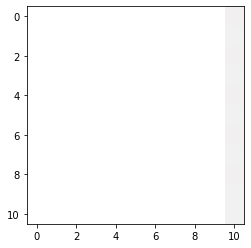

___ 8


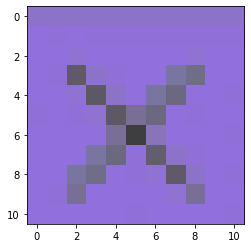

___ 5


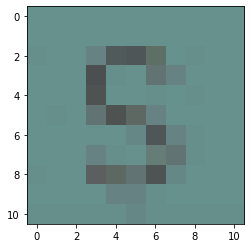

___ 6


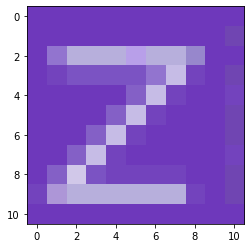

___ 2


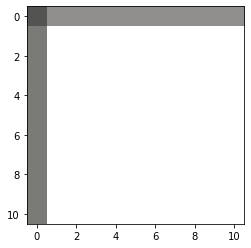

___ 9


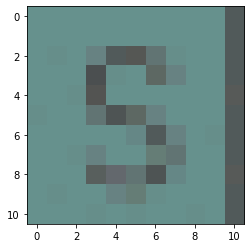

___ 6


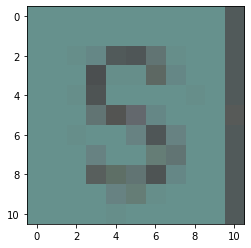

___ 6


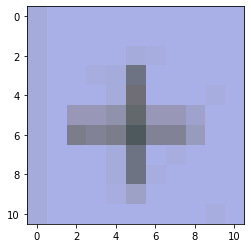

___ 7


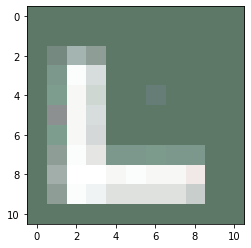

___ 4


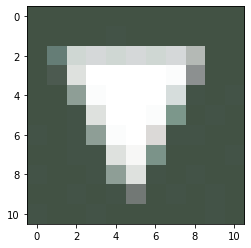

___ 0


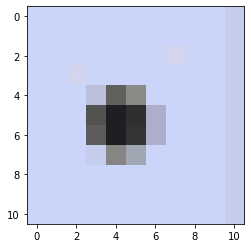

___ 7


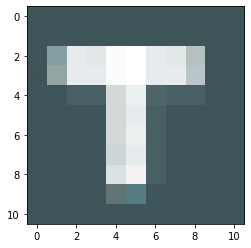

___ 1


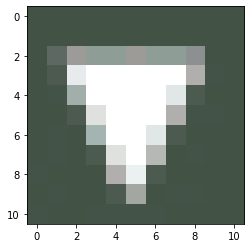

___ 0


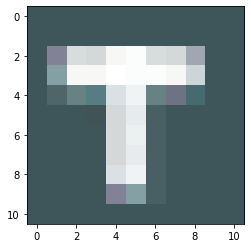

___ 1


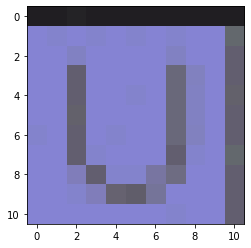

___ 5


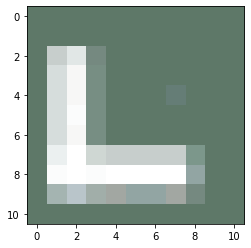

___ 4


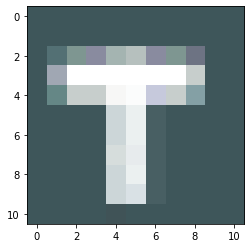

___ 1


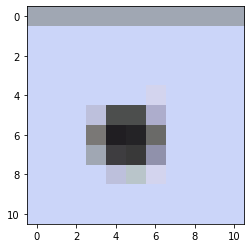

___ 7


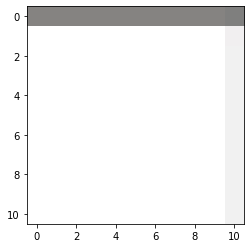

___ 5


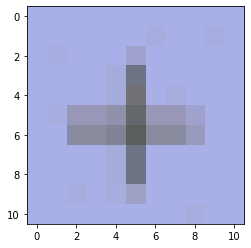

___ 7


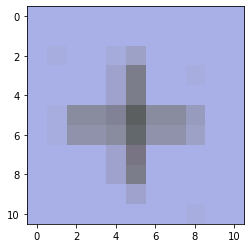

___ 6


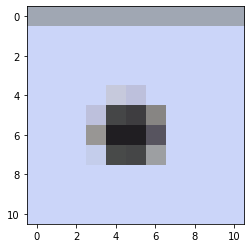

___ 7


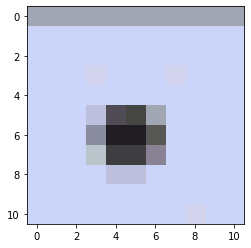

___ 7


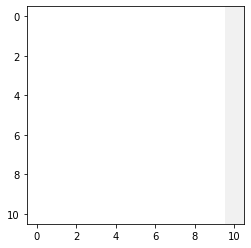

___ 8


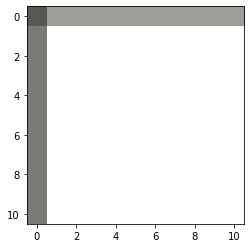

___ 9


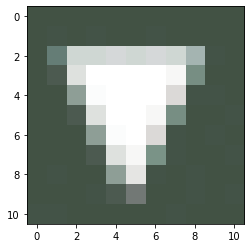

___ 0


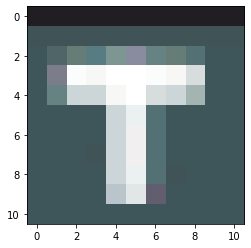

___ 1


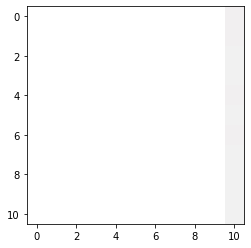

___ 8


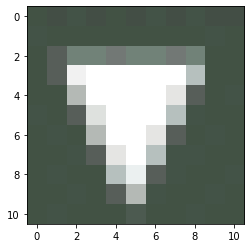

___ 0


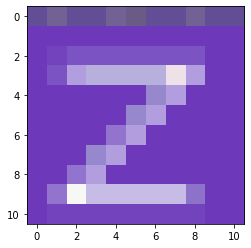

___ 2


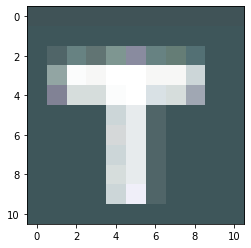

___ 1


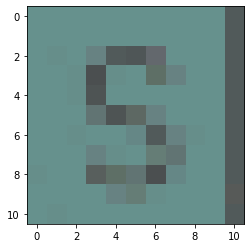

___ 6


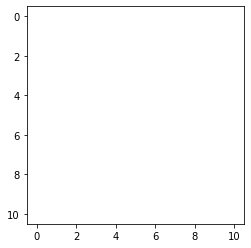

___ 8


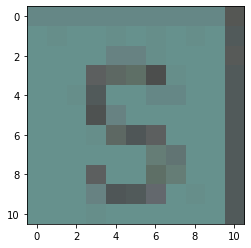

___ 9


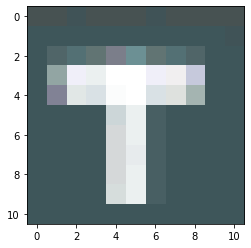

___ 1


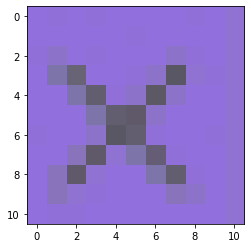

___ 3


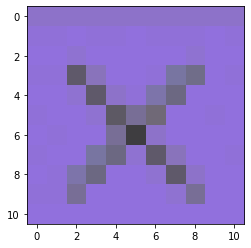

___ 5


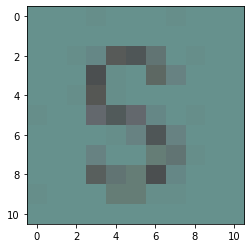

___ 6


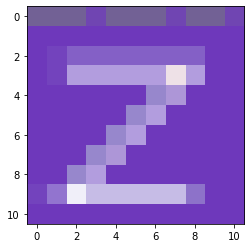

___ 2


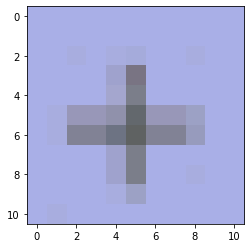

___ 7


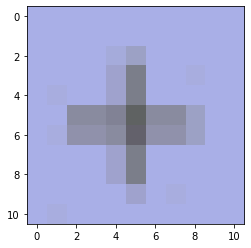

___ 6


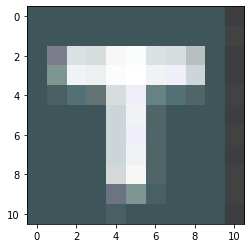

___ 1


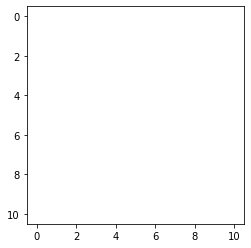

___ 8


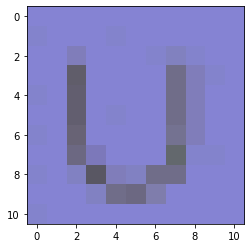

___ 3


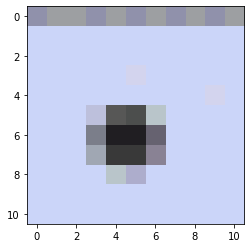

___ 7


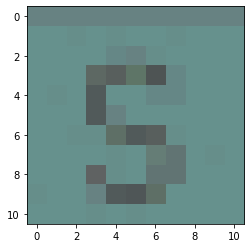

___ 9


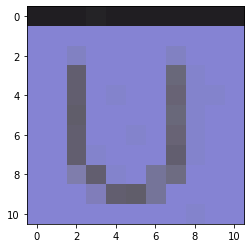

___ 5


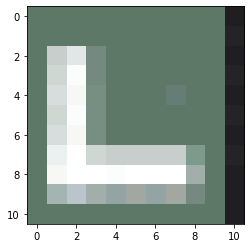

___ 4


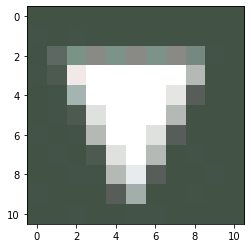

___ 0


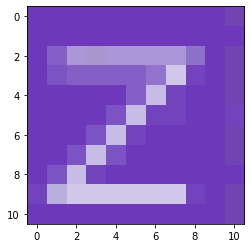

___ 2


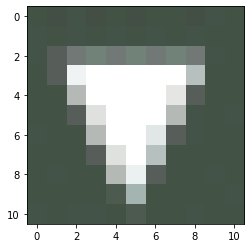

___ 0


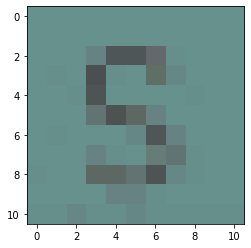

___ 6


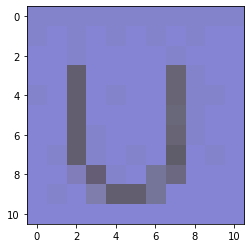

___ 3


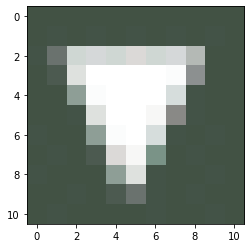

___ 0


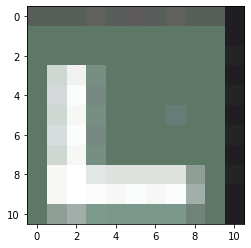

___ 4


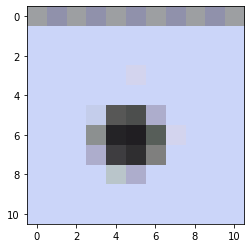

___ 7


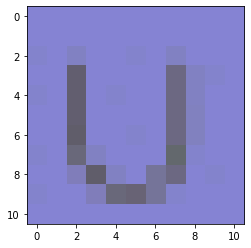

___ 3


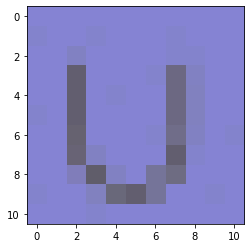

___ 3


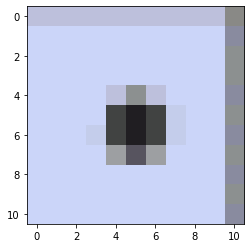

___ 7


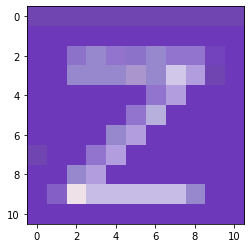

___ 2


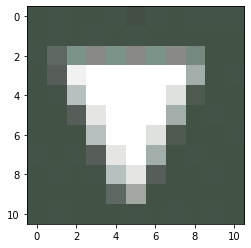

___ 0


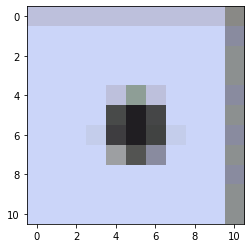

___ 7


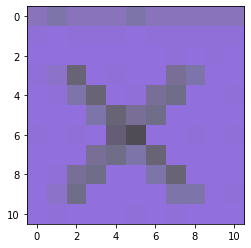

___ 5


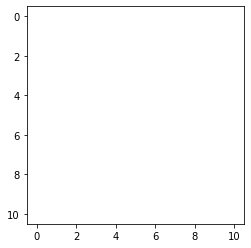

___ 8


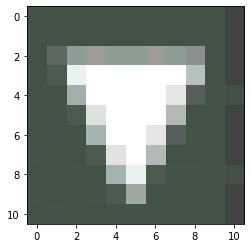

___ 0


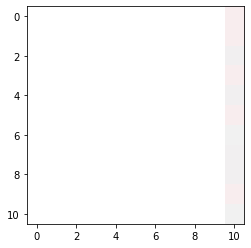

___ 8


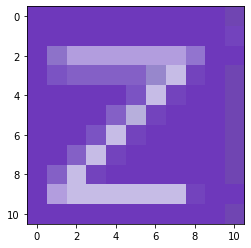

___ 2


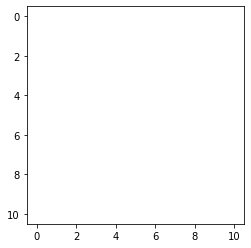

___ 8


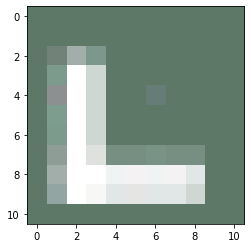

___ 4


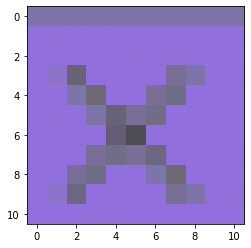

___ 5


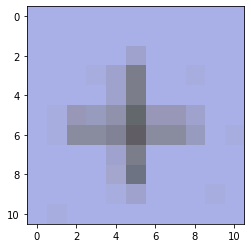

___ 7


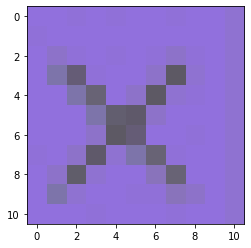

___ 3


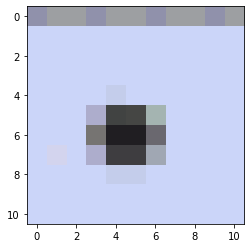

___ 7


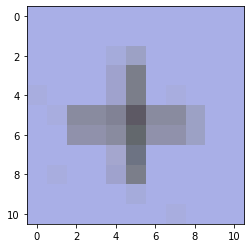

___ 6


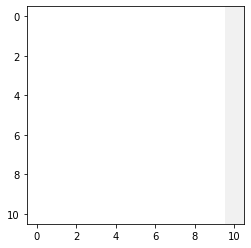

___ 8


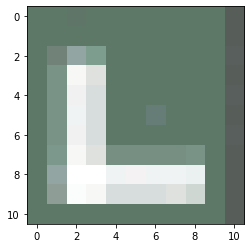

___ 4


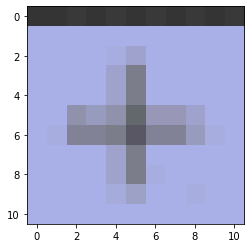

___ 9


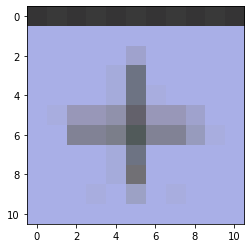

___ 9


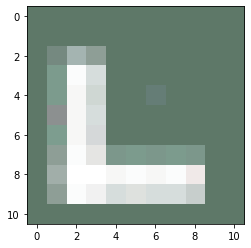

___ 4


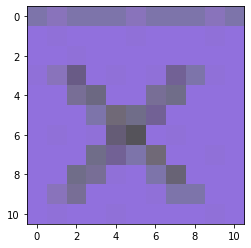

___ 5


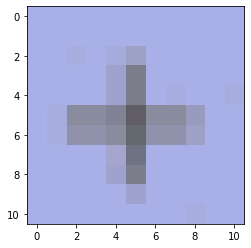

___ 6


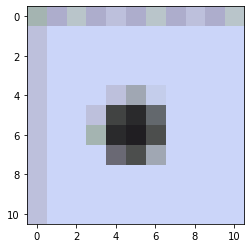

___ 7


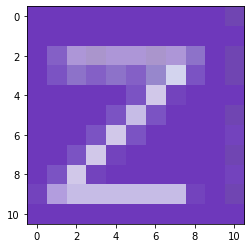

___ 2


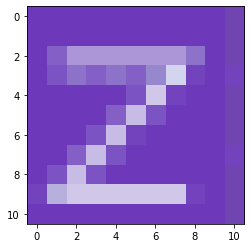

___ 2


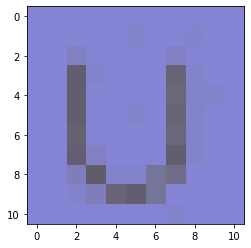

___ 3


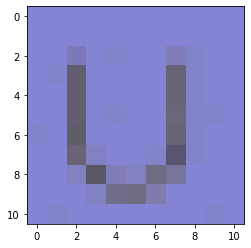

___ 3


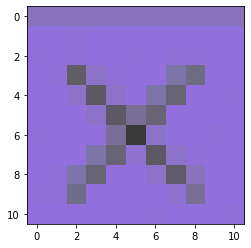

___ 5


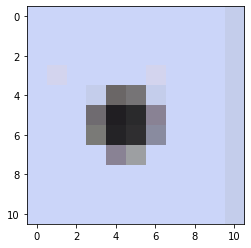

___ 7


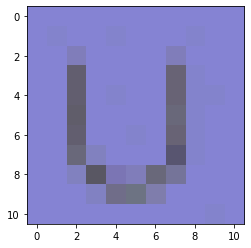

___ 3


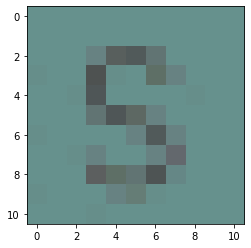

___ 6


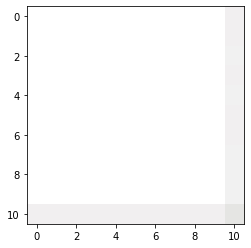

___ 8


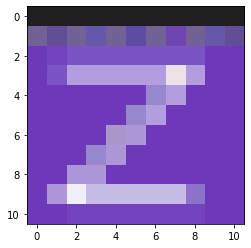

___ 2


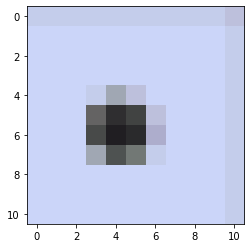

___ 7


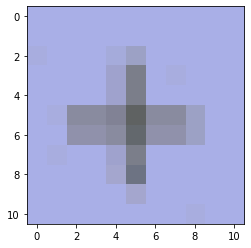

___ 6


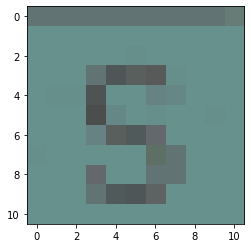

___ 5


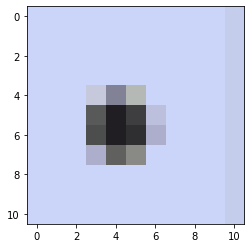

___ 7


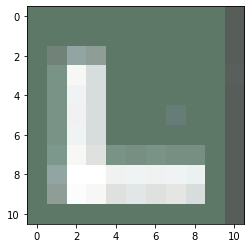

___ 4


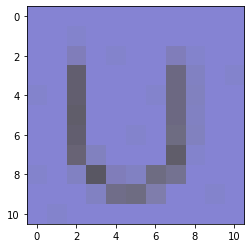

___ 3


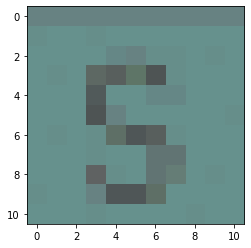

___ 9


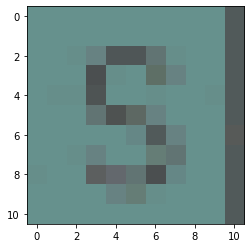

___ 6


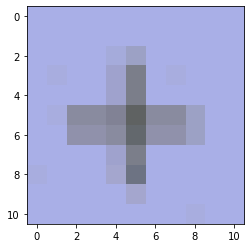

___ 6


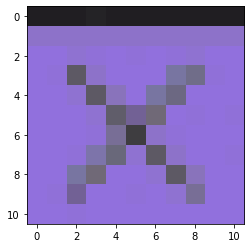

___ 5


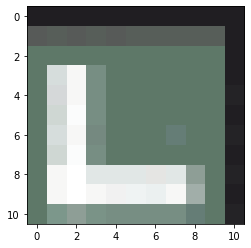

___ 4


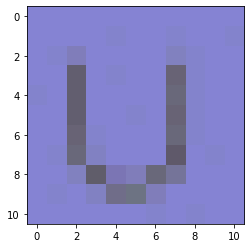

___ 3


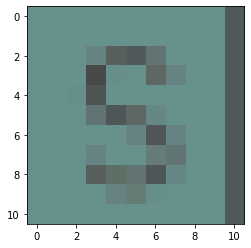

___ 6


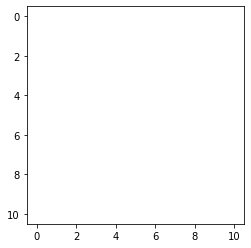

___ 8


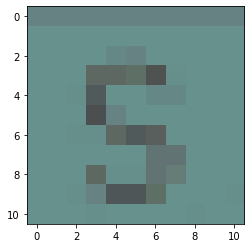

___ 9


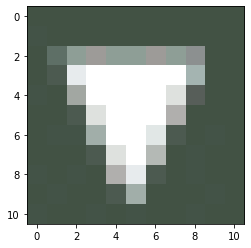

___ 0


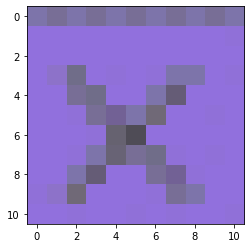

___ 5


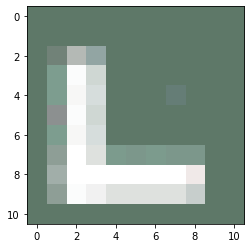

___ 4


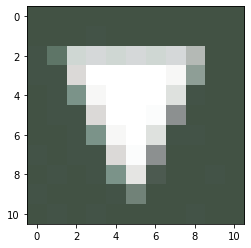

___ 0


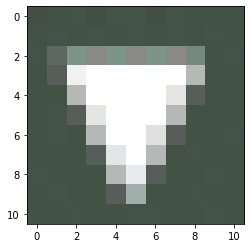

___ 0


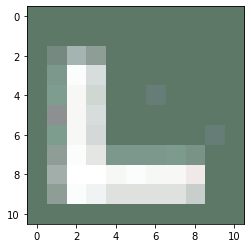

___ 4


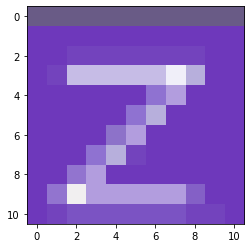

___ 2


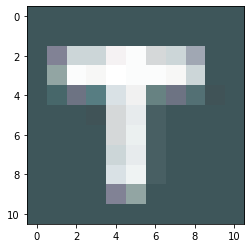

___ 1


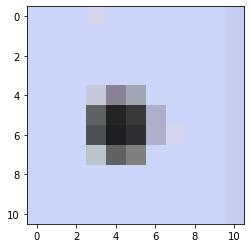

___ 7


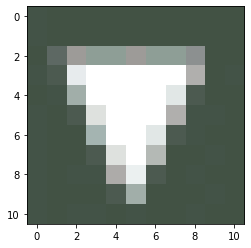

___ 0


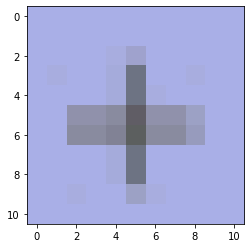

___ 7


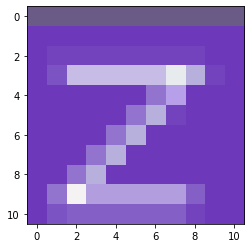

___ 2


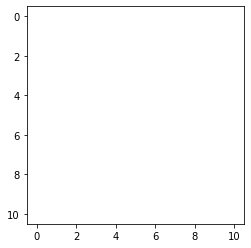

___ 8


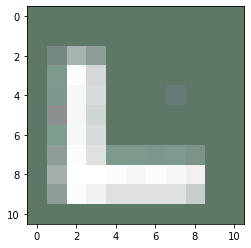

___ 4


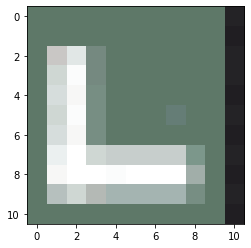

___ 4


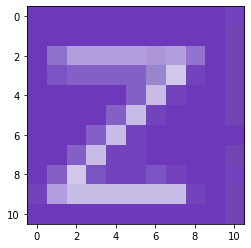

___ 2


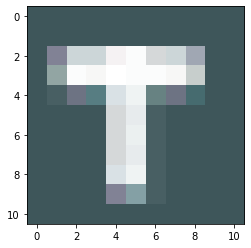

___ 1


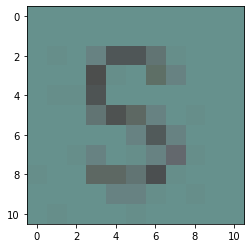

___ 6


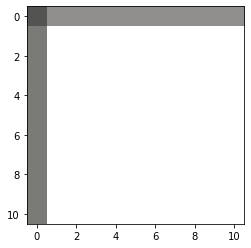

___ 9


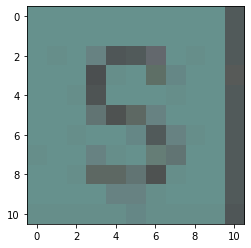

___ 6


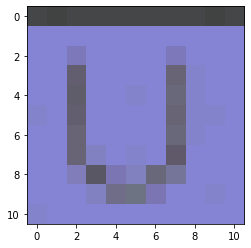

___ 5


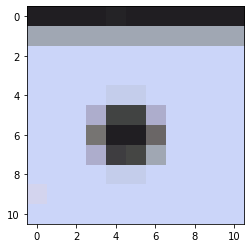

___ 9


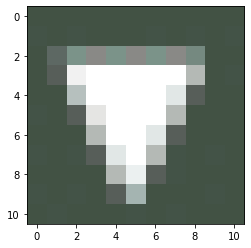

___ 0


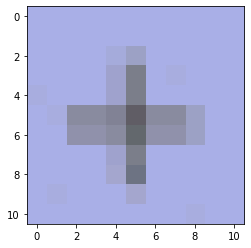

___ 6


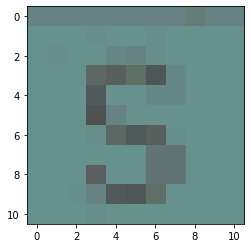

___ 9


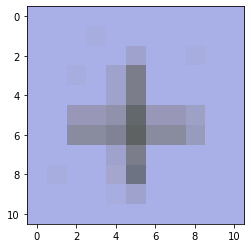

___ 6


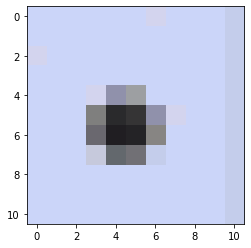

___ 7


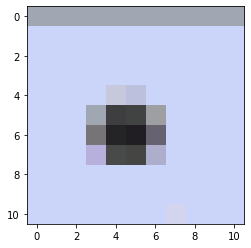

___ 7


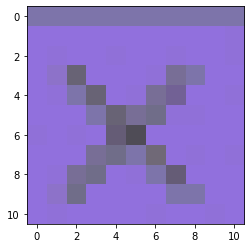

___ 5


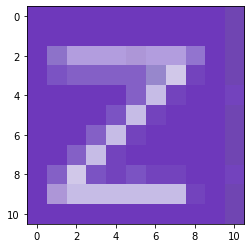

___ 2


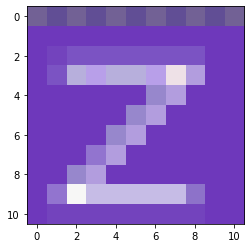

___ 2


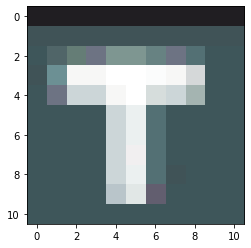

___ 1


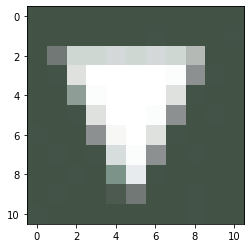

___ 0


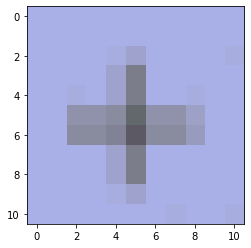

___ 7


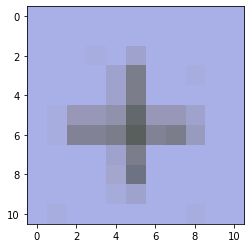

___ 7


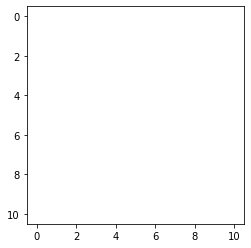

___ 8


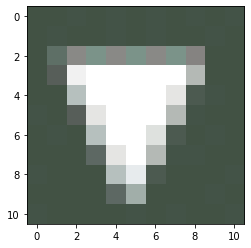

___ 0


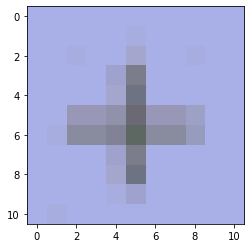

___ 6


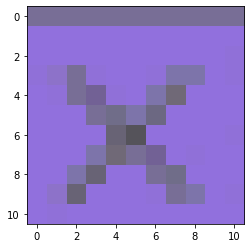

___ 5


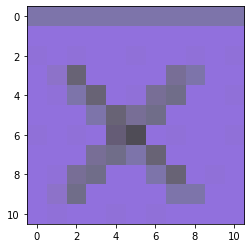

___ 5


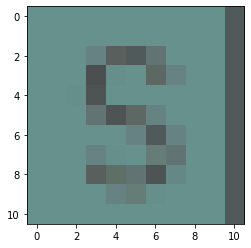

___ 3


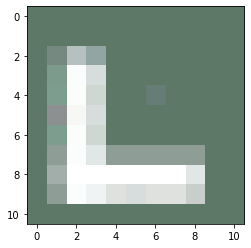

___ 4


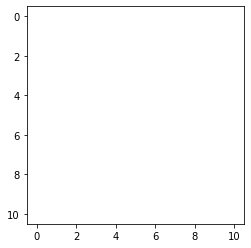

___ 8


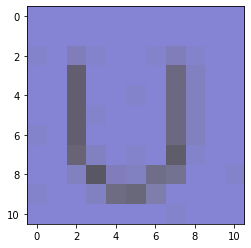

___ 3


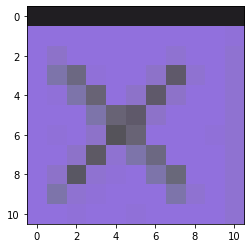

___ 5


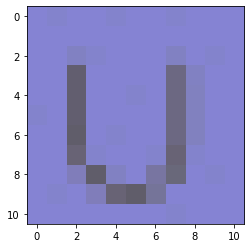

___ 3


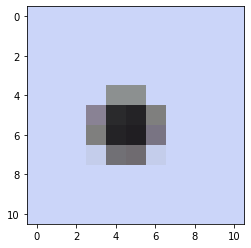

___ 7


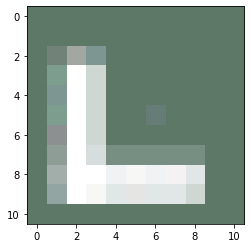

___ 4


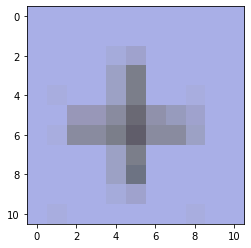

___ 7


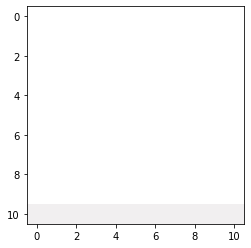

___ 8


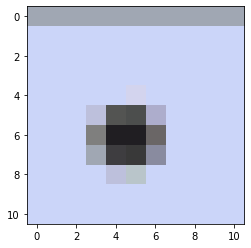

___ 7


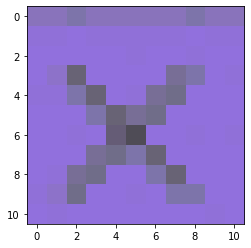

___ 5


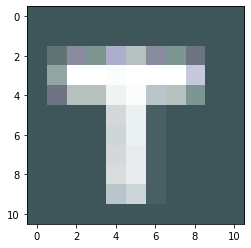

___ 1


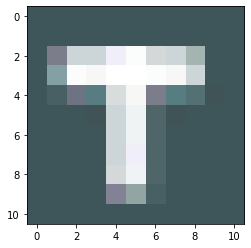

___ 1


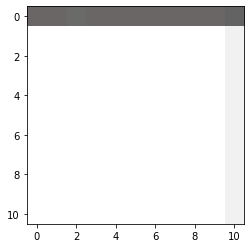

___ 5


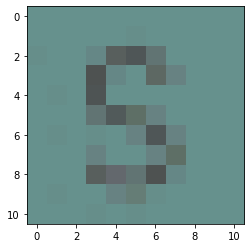

___ 6


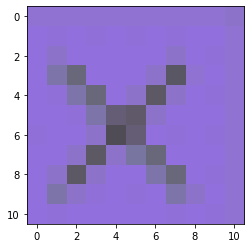

___ 3


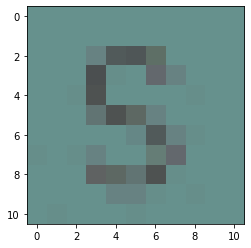

___ 6


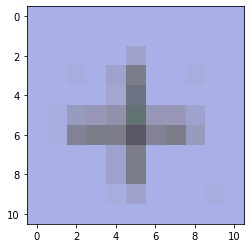

___ 7


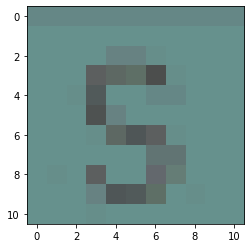

___ 9


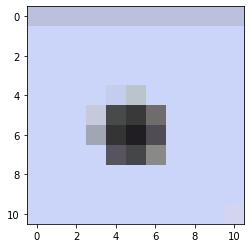

___ 7


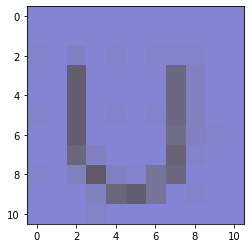

___ 3


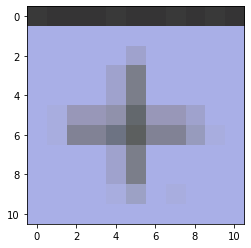

___ 9


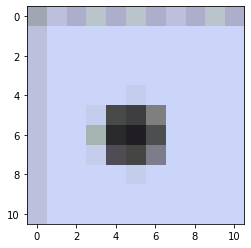

___ 7


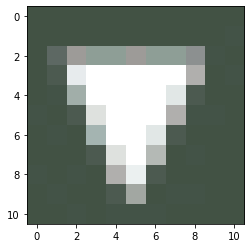

___ 0


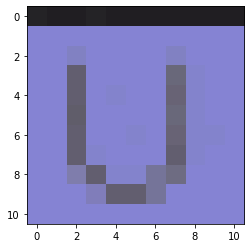

___ 5


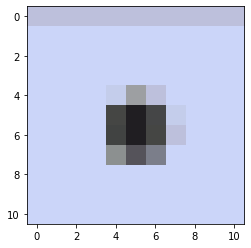

___ 7


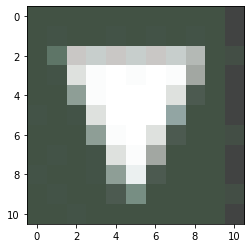

___ 0


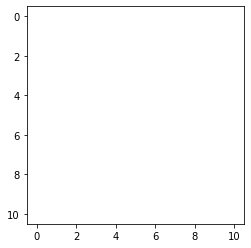

___ 8


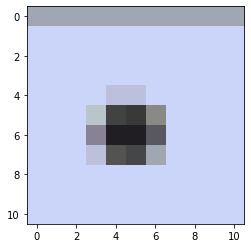

___ 7


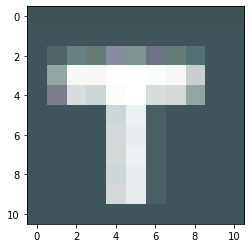

___ 1


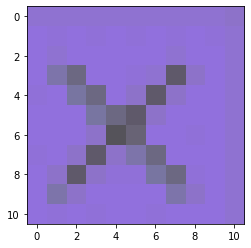

___ 3


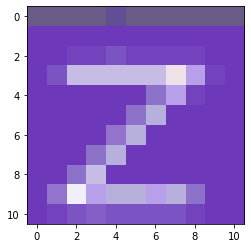

___ 2


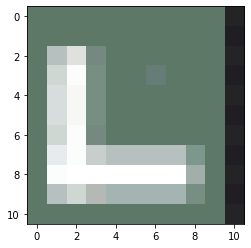

___ 4


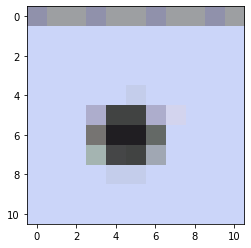

___ 7


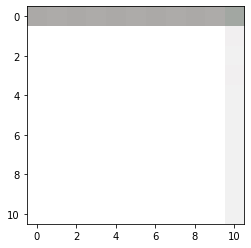

___ 5


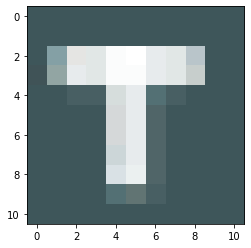

___ 1


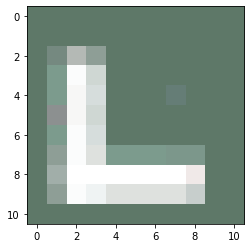

___ 4


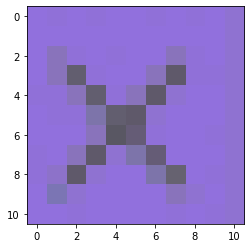

___ 3


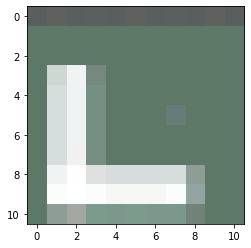

___ 4


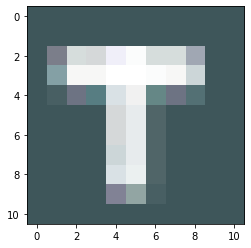

___ 1


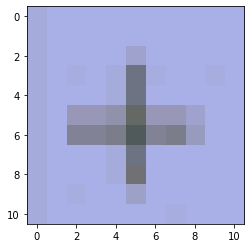

___ 7


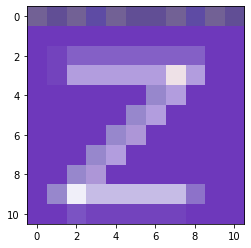

___ 2


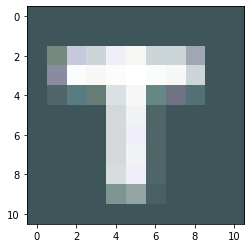

___ 1


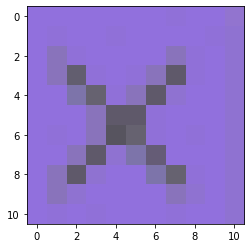

___ 3


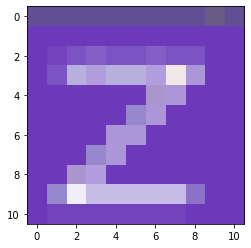

___ 2


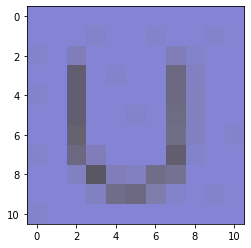

___ 3


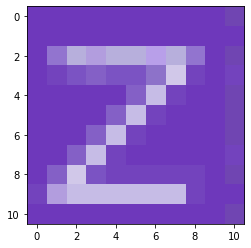

___ 2


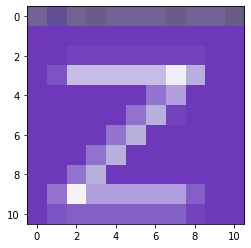

___ 2


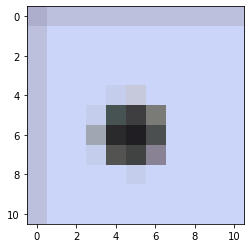

___ 7


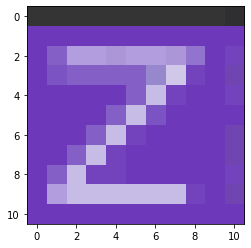

___ 5


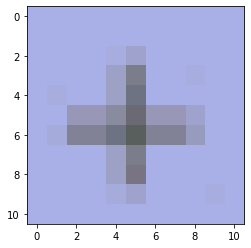

___ 7


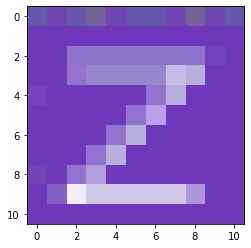

___ 2


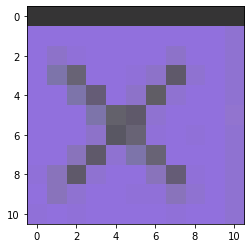

___ 5


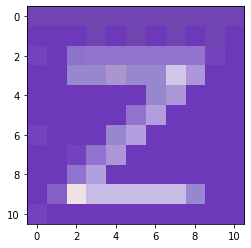

___ 2


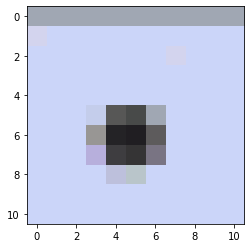

___ 7


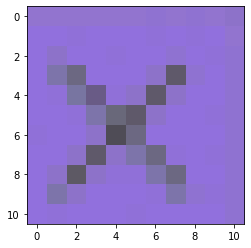

___ 3


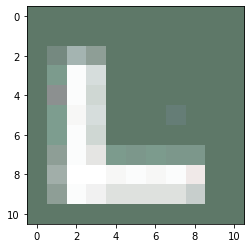

___ 4


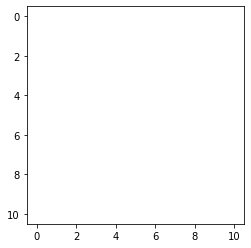

___ 8


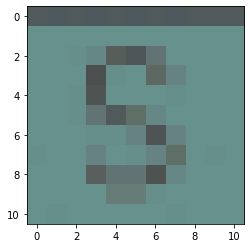

___ 5


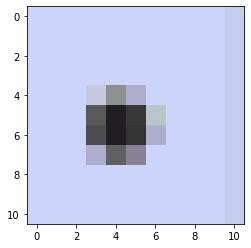

___ 7


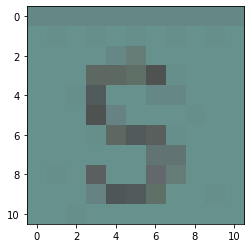

___ 9


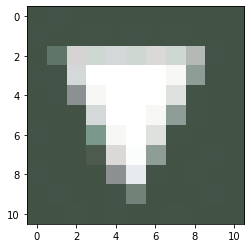

___ 0


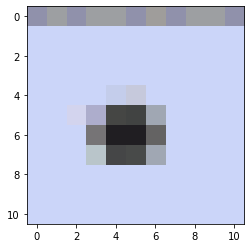

___ 7


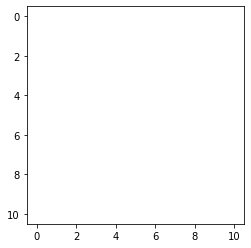

___ 8


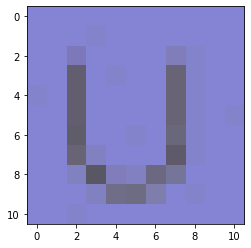

___ 3


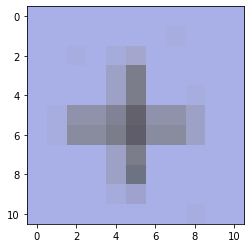

___ 7


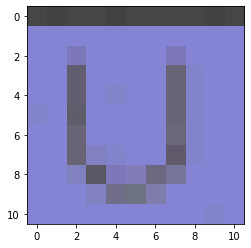

___ 5


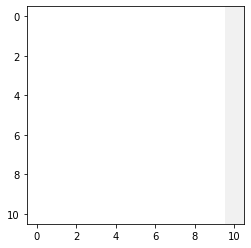

___ 8


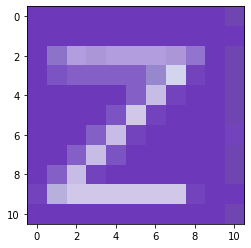

___ 2


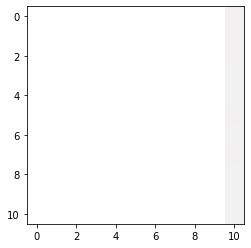

___ 8


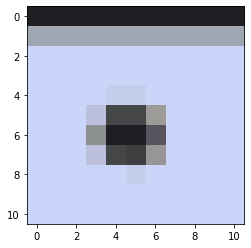

___ 9


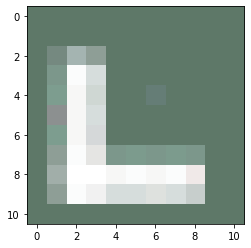

___ 4


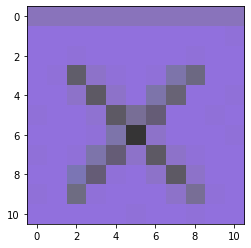

___ 5


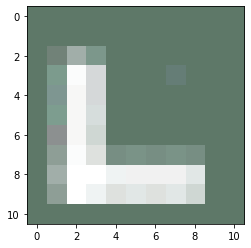

___ 4


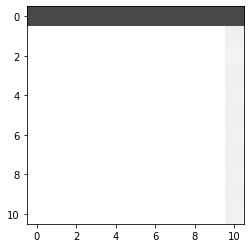

___ 5


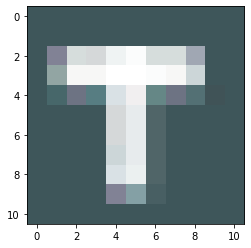

___ 1


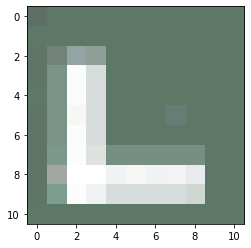

___ 4


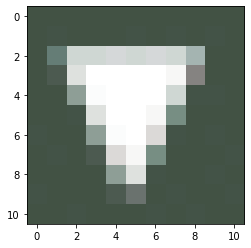

___ 0


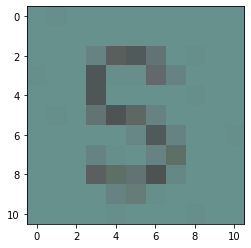

___ 6


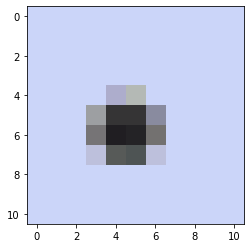

___ 7


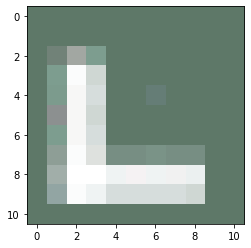

___ 4


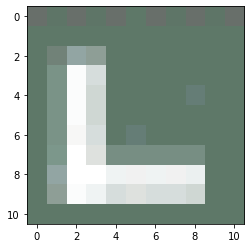

___ 4


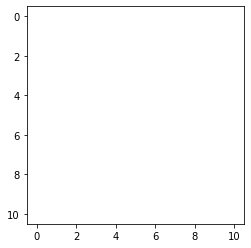

___ 8


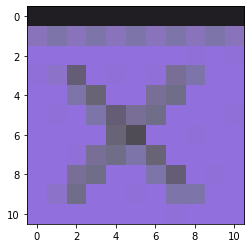

___ 5


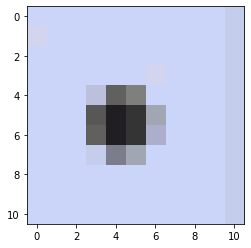

___ 7


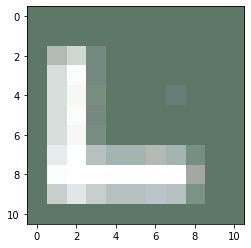

___ 4


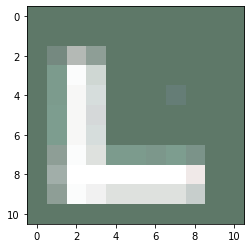

___ 4


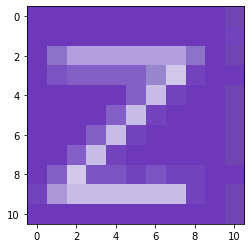

___ 2


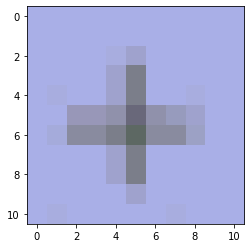

___ 6


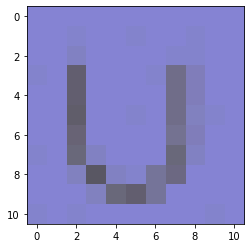

___ 3


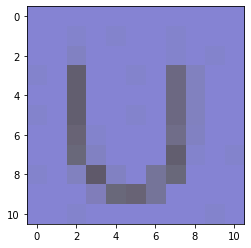

___ 3


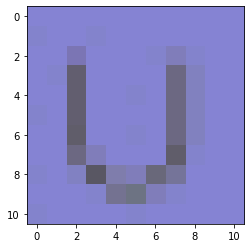

___ 3


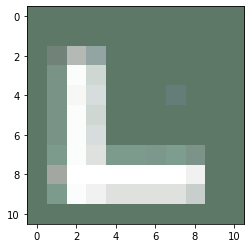

___ 4


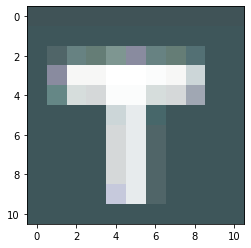

___ 1


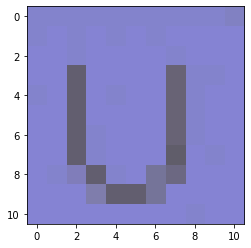

___ 3


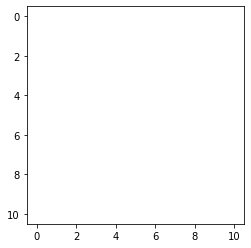

___ 8


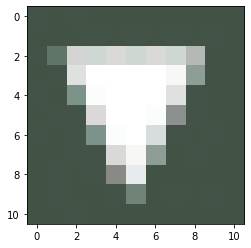

___ 0


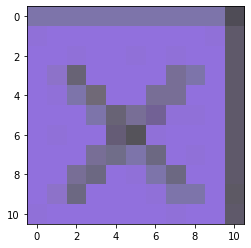

___ 5


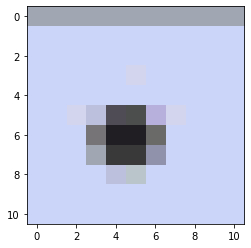

___ 7


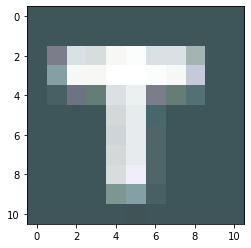

___ 1


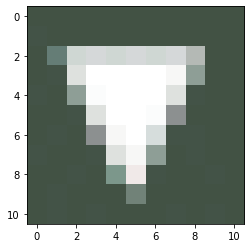

___ 0


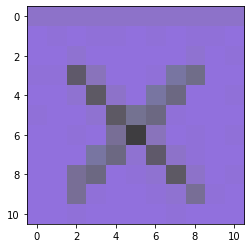

___ 5


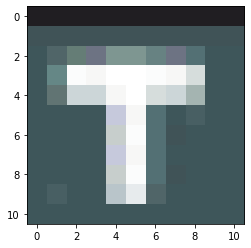

___ 1


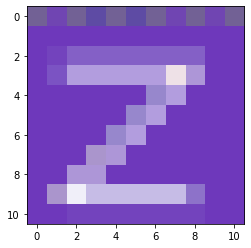

___ 2


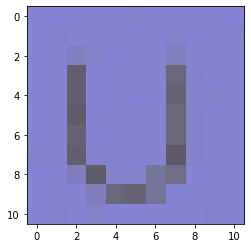

___ 3


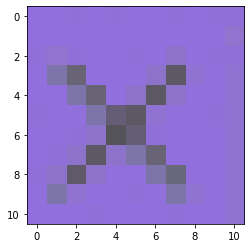

___ 3


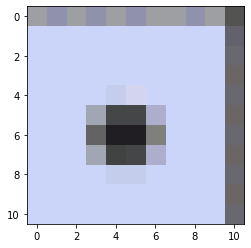

___ 7


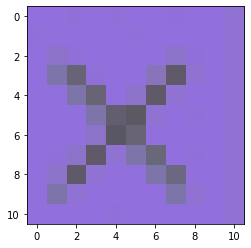

___ 3


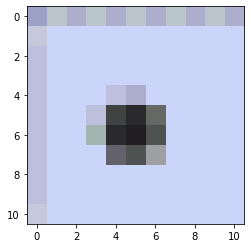

___ 7


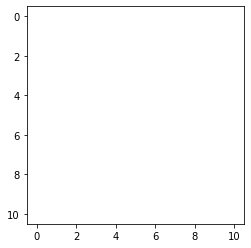

___ 8


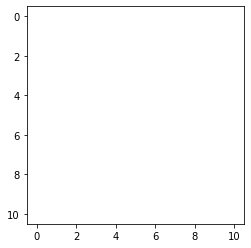

___ 8


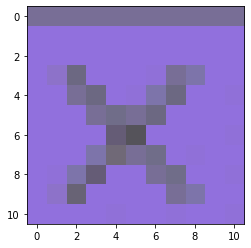

___ 5


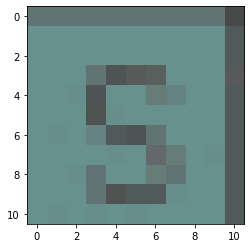

___ 9


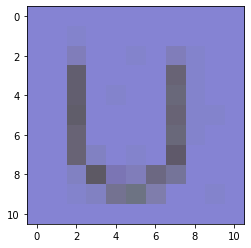

___ 3


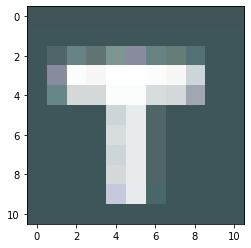

___ 1


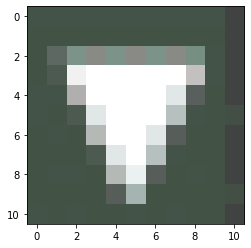

___ 0


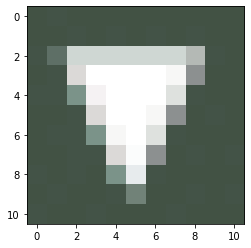

___ 0


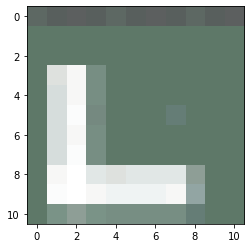

___ 4


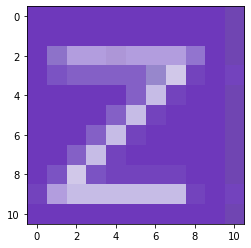

___ 2


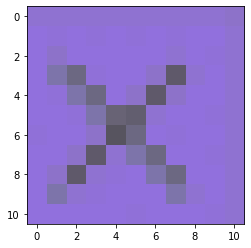

___ 3


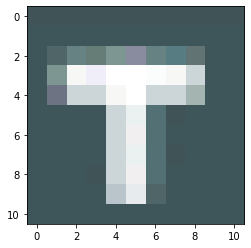

___ 1


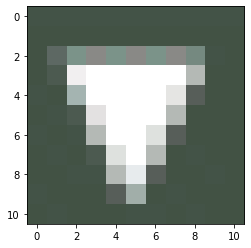

___ 0


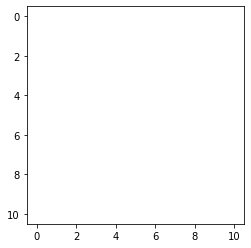

___ 8


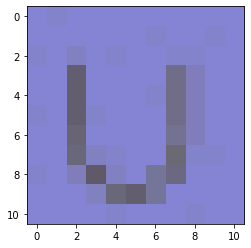

___ 3


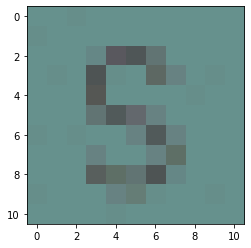

___ 6


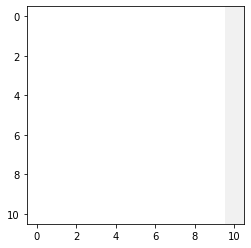

___ 8


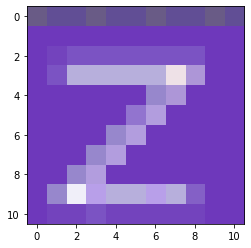

___ 2


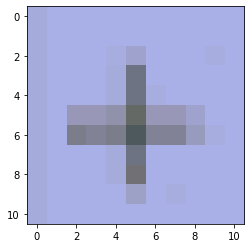

___ 7


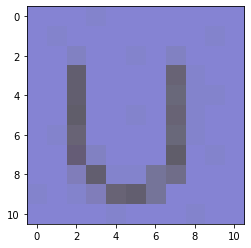

___ 3


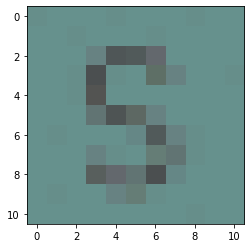

___ 6


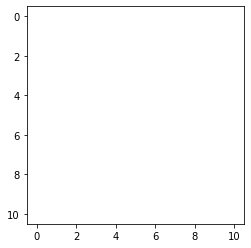

___ 8


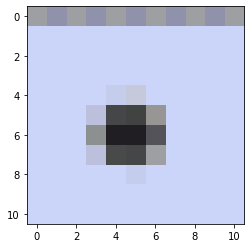

___ 7


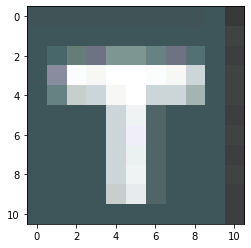

___ 1


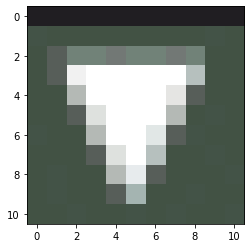

___ 0


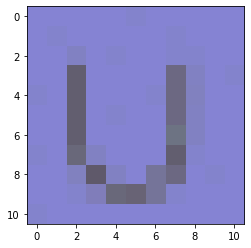

___ 3


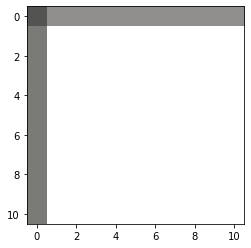

___ 9


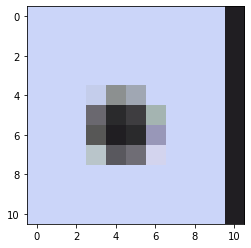

___ 7


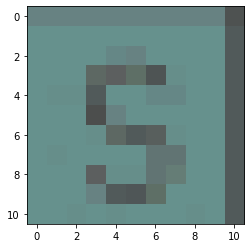

___ 9


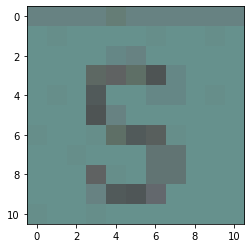

___ 9


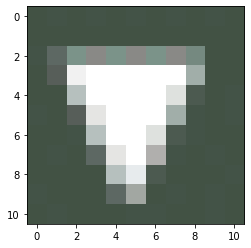

___ 0


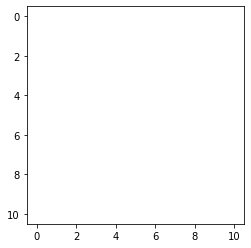

___ 8


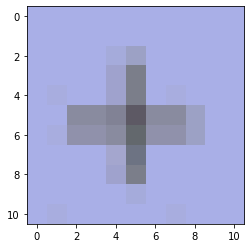

___ 6


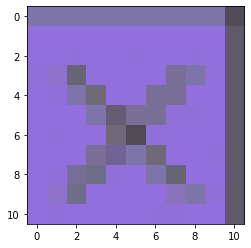

___ 5


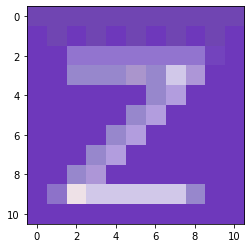

___ 2


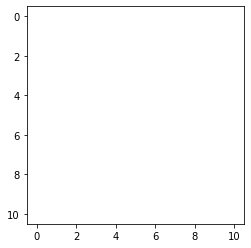

___ 8


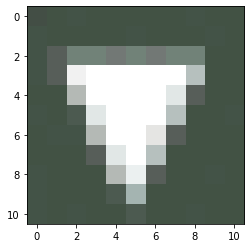

___ 0


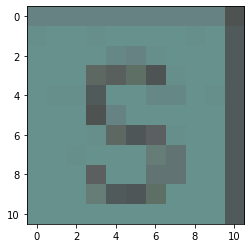

___ 9


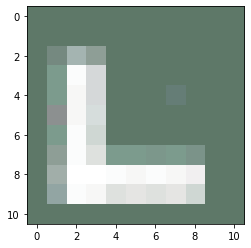

___ 4


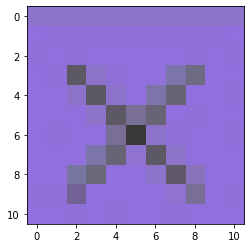

___ 5


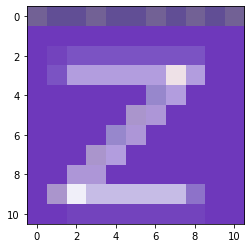

___ 2


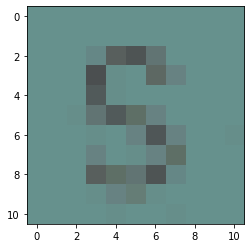

___ 6


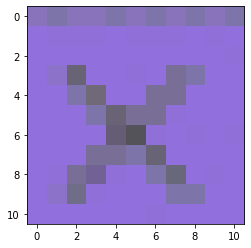

___ 5


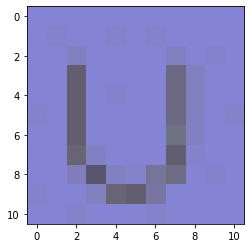

___ 3


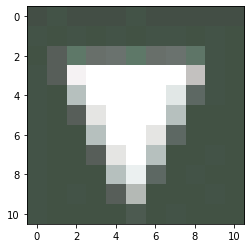

___ 0


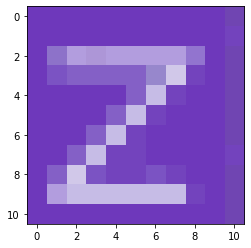

___ 2


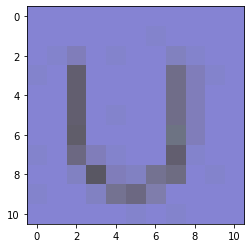

___ 3


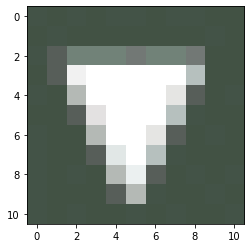

___ 0


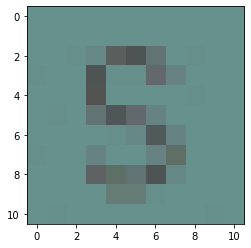

___ 6


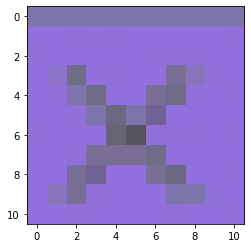

___ 5


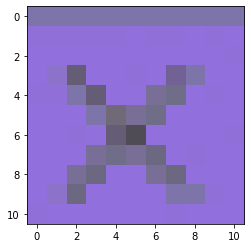

___ 5


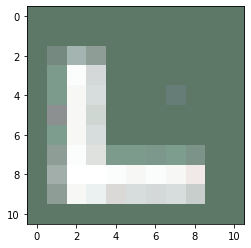

___ 4


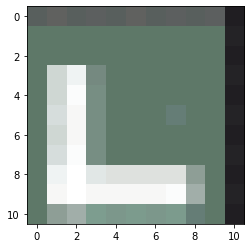

___ 4


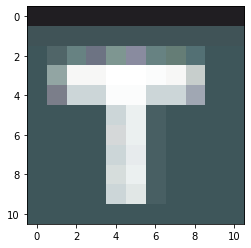

___ 1


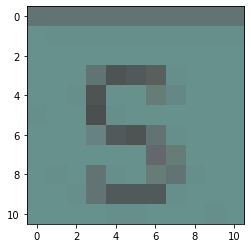

___ 9


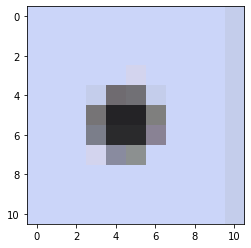

___ 7


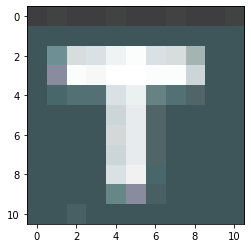

___ 1


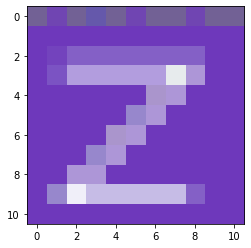

___ 2


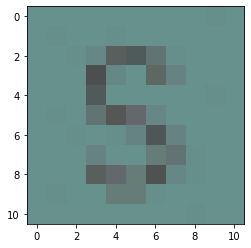

___ 6


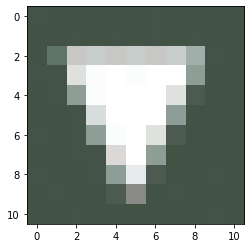

___ 0


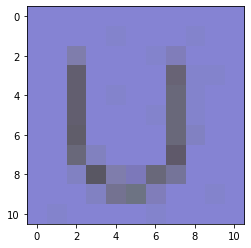

___ 3


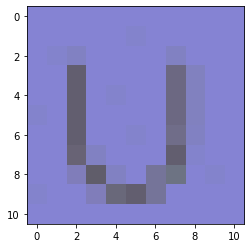

___ 3


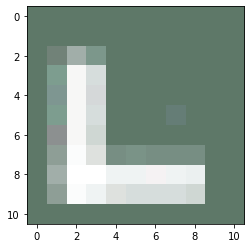

___ 4


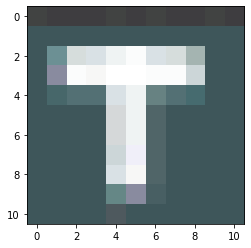

___ 1


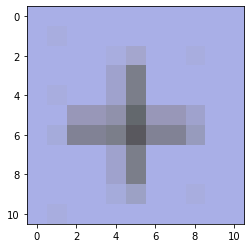

___ 7


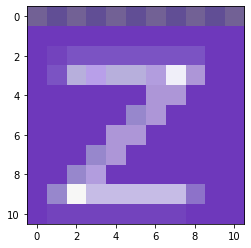

___ 2


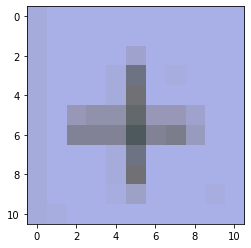

___ 7


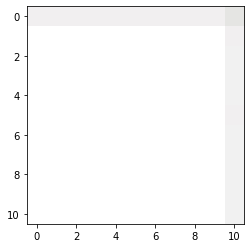

___ 8


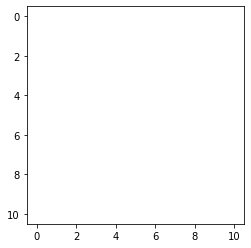

___ 8


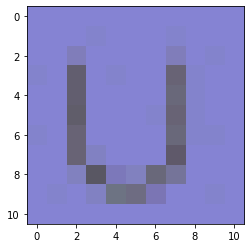

___ 3


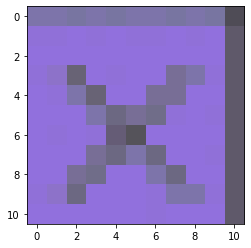

___ 5


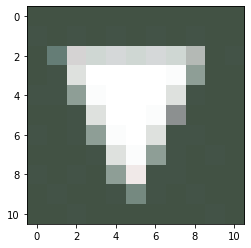

___ 0


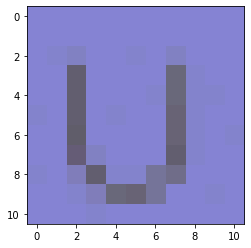

___ 3


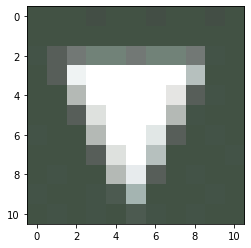

___ 0


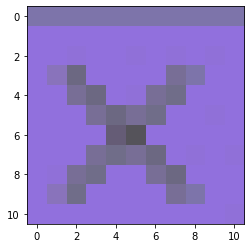

___ 5


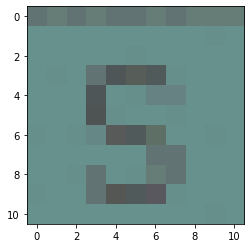

___ 9


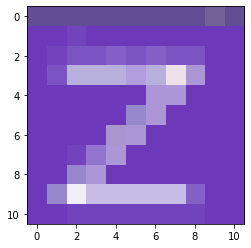

___ 2


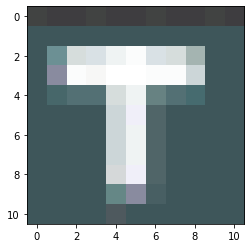

___ 1


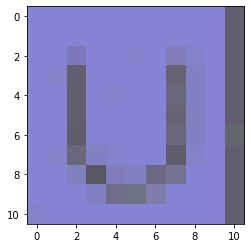

___ 3


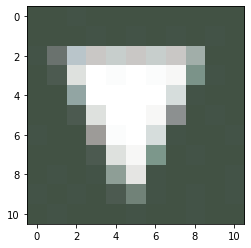

___ 0


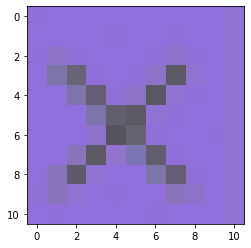

___ 3


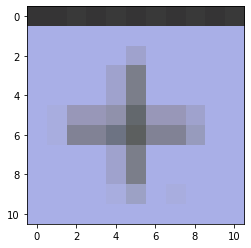

___ 9


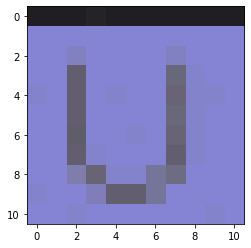

___ 5


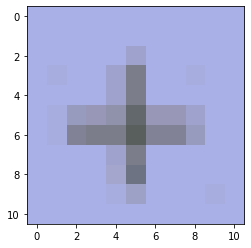

___ 7


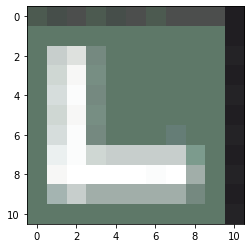

___ 4


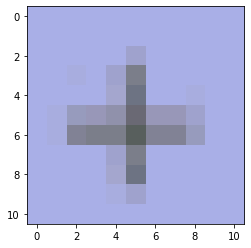

___ 7


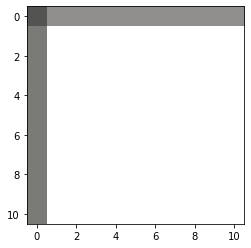

___ 9


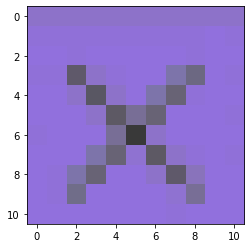

___ 5


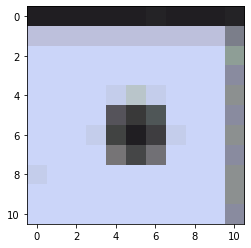

___ 9


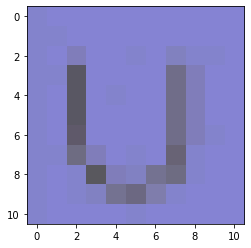

___ 3


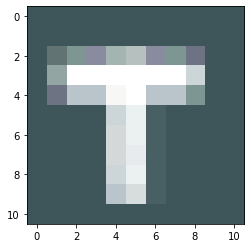

___ 1


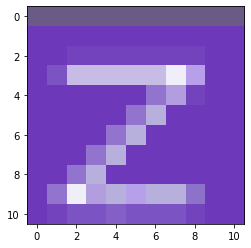

___ 2


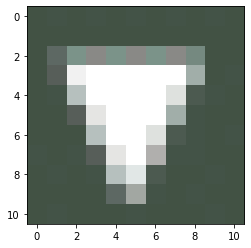

___ 0


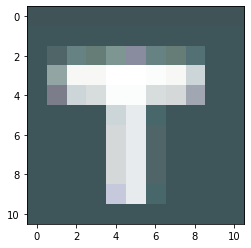

___ 1


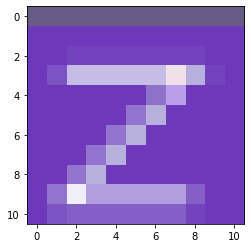

___ 2


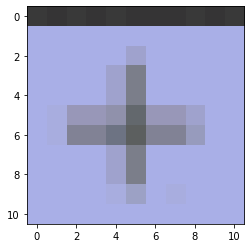

___ 9


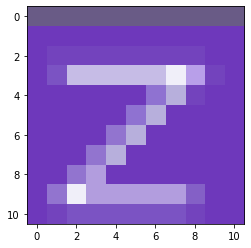

___ 2


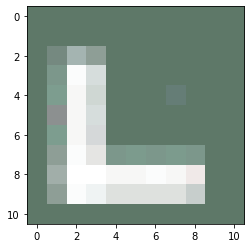

___ 4


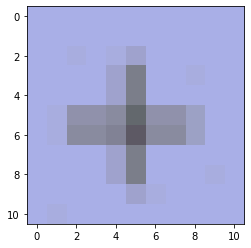

___ 7


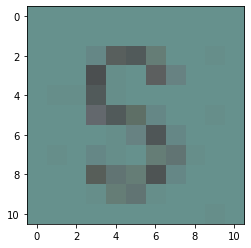

___ 6


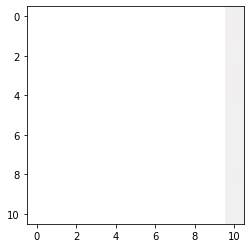

___ 8


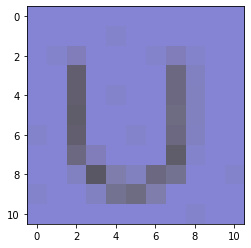

___ 3


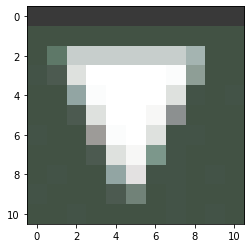

___ 0


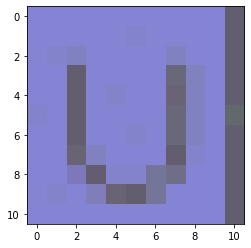

___ 3


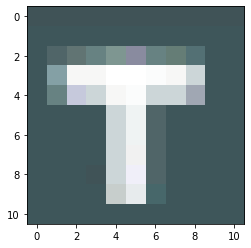

___ 1


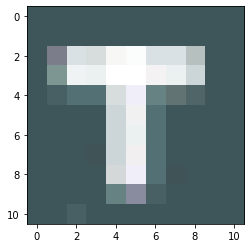

___ 1


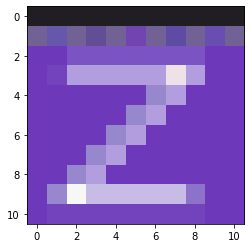

___ 2


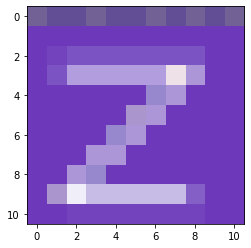

___ 2


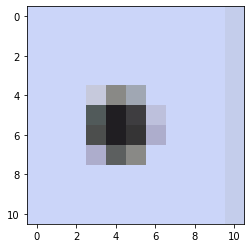

___ 7


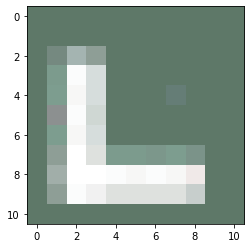

___ 4


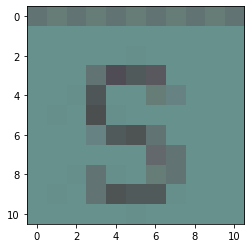

___ 9


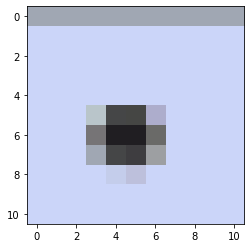

___ 7


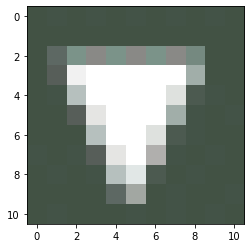

___ 0


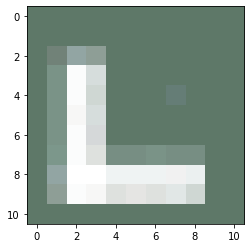

___ 4


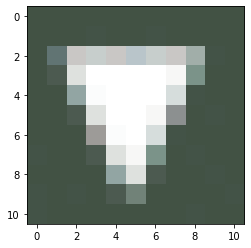

___ 0


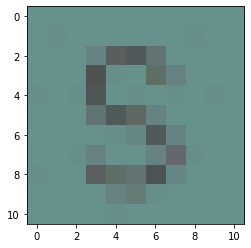

___ 6


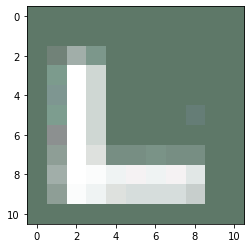

___ 4


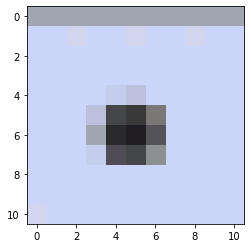

___ 7


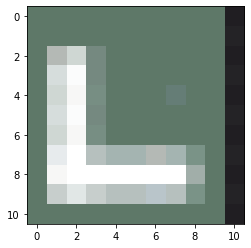

___ 4


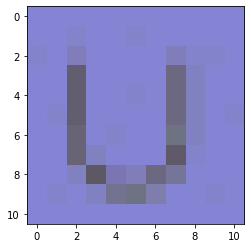

___ 3


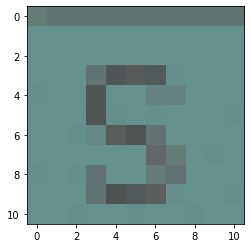

___ 9


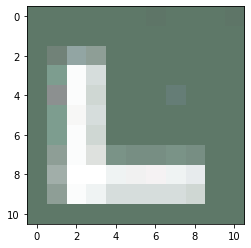

___ 4


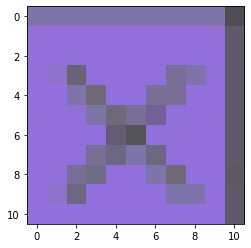

___ 5


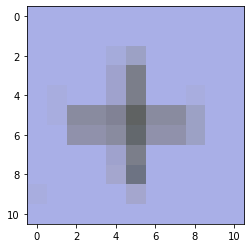

___ 6


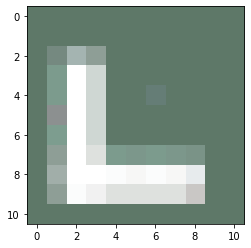

___ 4


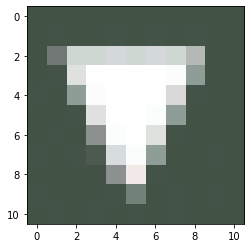

___ 0


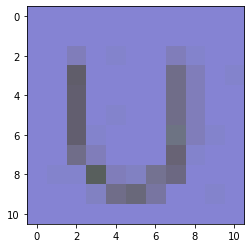

___ 3


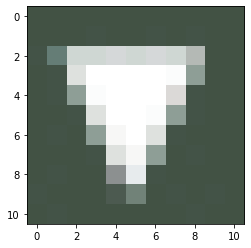

___ 0


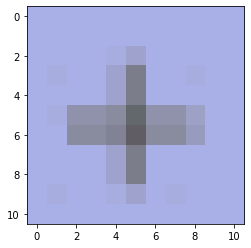

___ 7


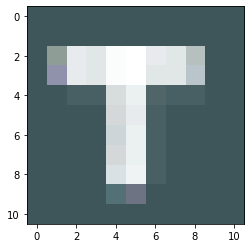

___ 1


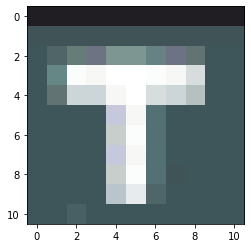

___ 1


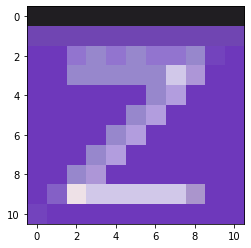

___ 2


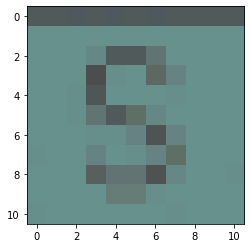

___ 5


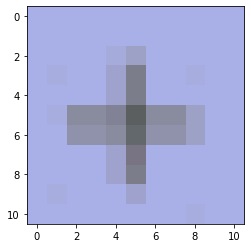

___ 6


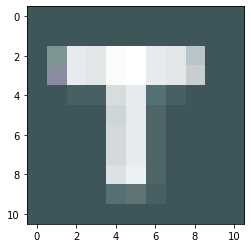

___ 1


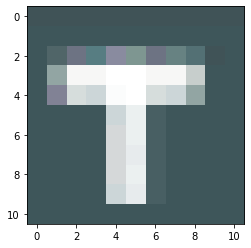

___ 1


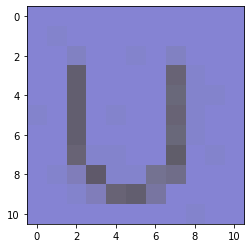

___ 3


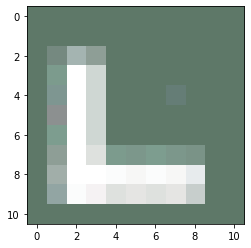

___ 4


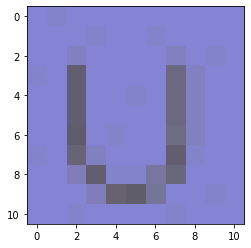

___ 3


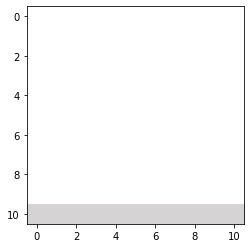

___ 8


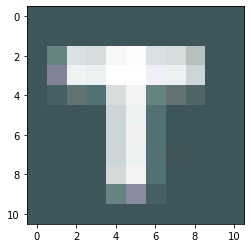

___ 1


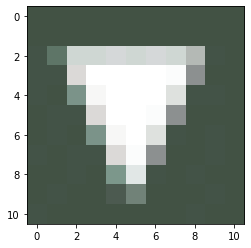

___ 0


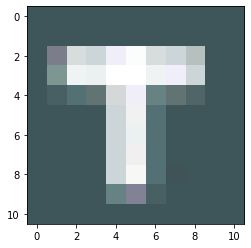

___ 1


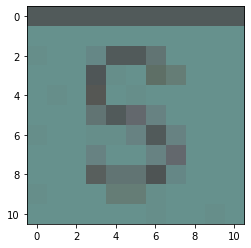

___ 5


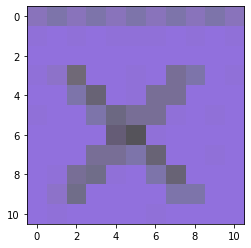

___ 5


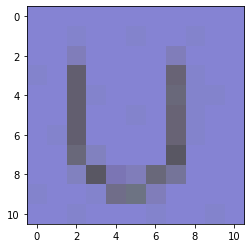

___ 3


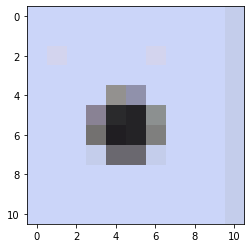

___ 7


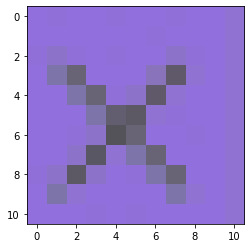

___ 3


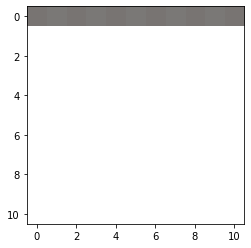

___ 5


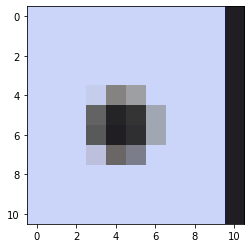

___ 7


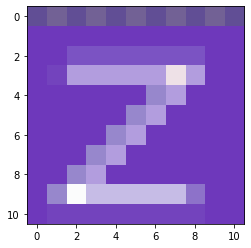

___ 2


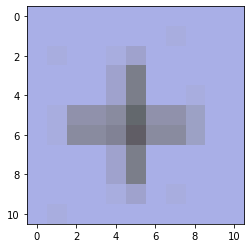

___ 7


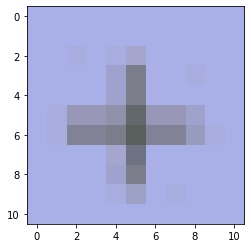

___ 7


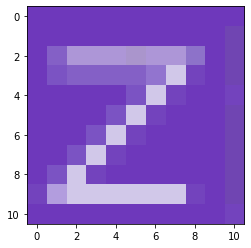

___ 2


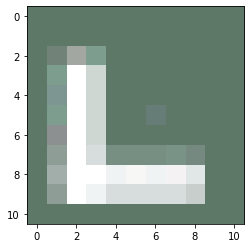

___ 4


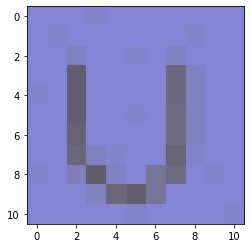

___ 3


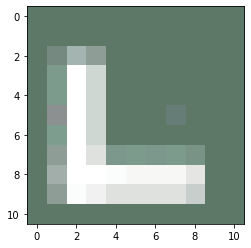

___ 4


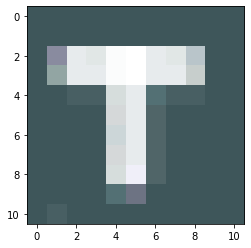

___ 1


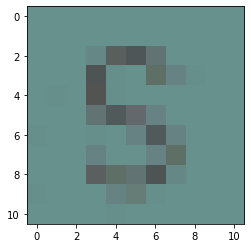

___ 6


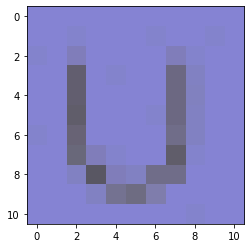

___ 3


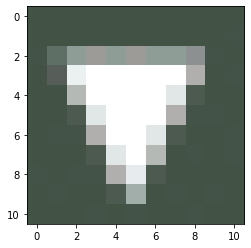

___ 0


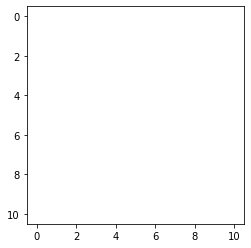

___ 8


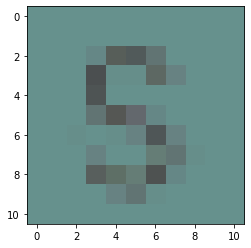

___ 6


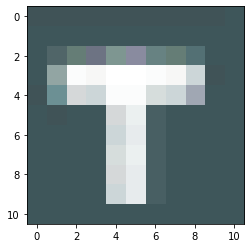

___ 1


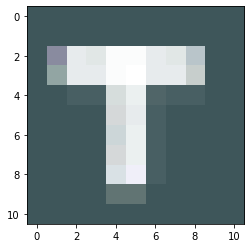

___ 1


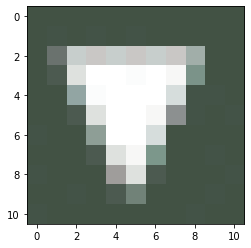

___ 0


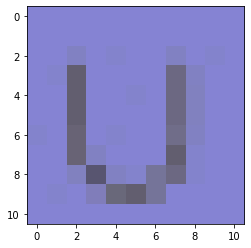

___ 3


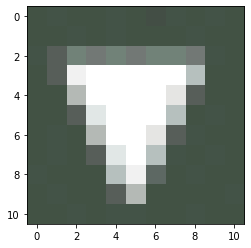

___ 0


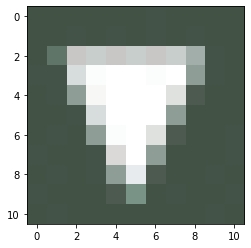

___ 0


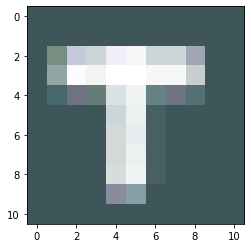

___ 1


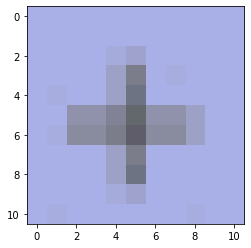

___ 7


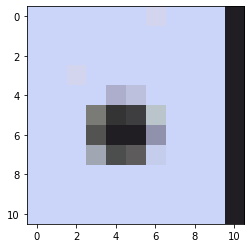

___ 7


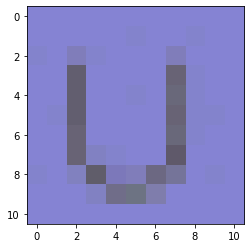

___ 3


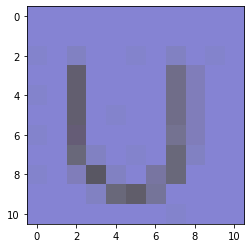

___ 3


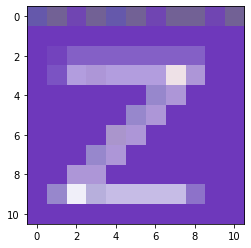

___ 2


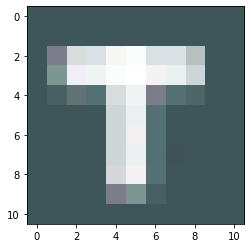

___ 1


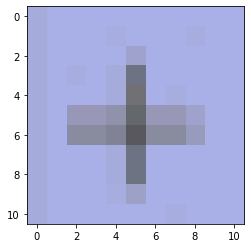

___ 7


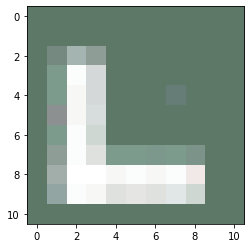

___ 4


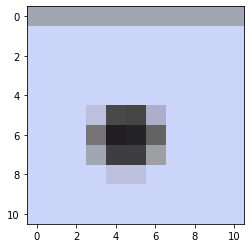

___ 7


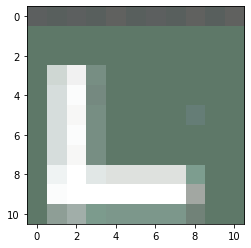

___ 4


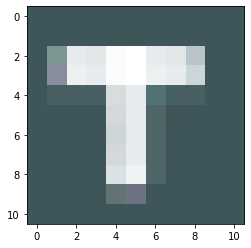

___ 1


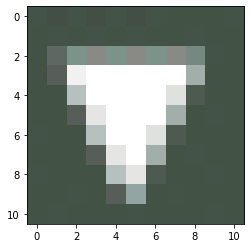

___ 0


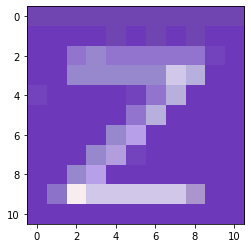

___ 2


In [185]:
from scipy.odr import Model
from torch.autograd import Variable
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

torch.save(model.state_dict(), 'aerialmodel60epochComposeUpd.pth')
model = ResNetClusterisator()
model.load_state_dict(torch.load('aerialmodel60epochComposeUpd.pth'))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model=torch.load('aerialmodel.pth')
# model = ResNetClusterisator()
# for param in model.parameters():
#     print("Param before eval: ", param[0])
# model.load_state_dict(torch.load('aerialmodel.pth'))


# for param in model.parameters():
#     print("Param after eval: ",  param[0])

test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                     ])
images = [cv2.imread(file) for file in glob.glob("Dataset_with_no_labels/*.png")]
data=[]
for idx, img in enumerate(images):
     image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
     image = cv2.resize(image, (28, 28))
     image = np.array(image)
     # image = torch.from_numpy(image)
     data.append(image)
     image_tensor = test_transforms(image).float()
     image_tensor = image_tensor.unsqueeze_(0)*255
     input = Variable(image_tensor)
     input = input.to(device)
     output = model(input, False)
     index = output.data.cpu().numpy().argmax()

     plt.imshow(img, cmap='gray')
     plt.show()
     dir_name = 'Clustered Images 60 epoch compose update/' + str(index)
     if not os.path.exists(dir_name):
        os.makedirs(dir_name)
     cv2.imwrite(dir_name + '/' + str(idx)  + '.png', img)
     print("___ %d" % index)

#
# data = torch.tensor(data, device="cpu")
#
# img = images[0]
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, (28, 28))
# img_tensor = torch.tensor(img, device="cpu")
# outputs = model(data)


### Clustering

Than we compose two labelings -- the original one and the one which is outputted by the model. Note, that in a fair clustering setting the original labels are not available, so this method is applicable only in testing _clustering method_ on a labeled dataset. 

In [37]:
original_labels, cluster_labels = get_cluster_labeling(
    model, dataloader_train, device=device
)

KeyError: 'label'

We visualize the results with a set of histograms. Each histograms corresponds to a certain original class and shows, how  clustering labels are distributed along this class. The best case is when all the histograms have a single huge bin. 

In [39]:
visualise_clusetering_results(original_labels, cluster_labels)

NameError: name 'original_labels' is not defined

models performanceWe can also compute some clustering scores to get a numerical metrics of the clustering. Here I use [adjusted_rand_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html), [homogeneity_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html), [completeness_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html). The closer the values to the ones, the better:

In [40]:
adj_score = adjusted_rand_score(cluster_labels, original_labels)
hom_score = homogeneity_score(cluster_labels, original_labels)
compl_score = completeness_score(cluster_labels, original_labels)
print("Adjusted rand score: %.3f " % adj_score)
print("Homogeneity score: %.3f " % adj_score)
print("Completeness score: %.3f" % compl_score)

NameError: name 'cluster_labels' is not defined

### Semi-supervised classification

To evaluate the model in semi-supervised classification setting, we use our val dataloader, which fetches the data previously unseen by the model

In [41]:
original_labels, cluster_labels = get_cluster_labeling(
    model, dataloader_val, device=device
)

NameError: name 'dataloader_val' is not defined

We visualize the labels in the same way as before:

In [42]:
visualise_clusetering_results(original_labels, cluster_labels)

NameError: name 'original_labels' is not defined

To compute usual classification metrics, we need to create a mapping from cluster labels to original labels. Function ```create_mapping``` does it by assigning the most frequent class present in the cluster:

In [43]:
cluster_mapping = create_mapping(original_labels, cluster_labels)
cluster_labels_mapped = [cluster_mapping[x] for x in cluster_labels]

NameError: name 'original_labels' is not defined

The mapping is:

In [44]:
print_mapping(cluster_mapping)

NameError: name 'cluster_mapping' is not defined

Now the largest bins should be at the places which correspond to the original labels:

In [45]:
visualise_clusetering_results(original_labels, cluster_labels_mapped)

NameError: name 'original_labels' is not defined

The accuracy is:

In [46]:
accuracy_score(original_labels, cluster_labels_mapped)

NameError: name 'original_labels' is not defined

If the training was done correctly the accuracy should be grater than 0.9. The autors of the <a href="https://arxiv.org/abs/1807.06653">original paper</a> achieved the accuracy of 99.2%

## Conclusion

If everything went well, by this line you have successfully trained and evaluated IIC model. Congrats!